# Project: Dog Breed Classification App 

### Deep Learning Nanodegree - Convolutional Neural Network


---
### Why We're Here 

In this project, we will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, our code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.

In this real-world setting, we will piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed. Our imperfect solution will nonetheless create a fun user experience!


### Importing Dog Dataset

In the code cell below, we will import a dataset of dog images and populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# defining a function to load train, test, and validation datasets

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# loading train, test, and validation datasets

train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# loading list of dog names

dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# printing statistics about the dataset

print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Importing Human Dataset

In the code cell below, we will import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# loading filenames in shuffled human dataset

human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# printing statistics about the dataset

print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Detecting Humans

We will use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we will demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


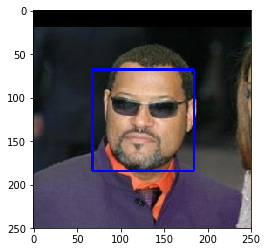

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extracting pre-trained face detector

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# loading color (BGR) image

img = cv2.imread(human_files[3])

# converting BGR image to grayscale

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# finding faces in image

faces = face_cascade.detectMultiScale(gray)

# printing number of faces detected in the image

print('Number of faces detected:', len(faces))

# getting bounding box for each detected face

for (x,y,w,h) in faces:
    # adding bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# converting BGR image to RGB for plotting

cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# displaying the image, along with bounding box

plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Writing a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# face_detector function that returns "True" if face is detected in image stored at img_path

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assessing the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face. We will extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## Testing the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

faces_in_Human = 0
faces_in_Dogs = 0

for file in human_files_short:
    if face_detector(file):
        faces_in_Human += 1
        
for file in dog_files_short:
    if face_detector(file):
        faces_in_Dogs += 1
        
print('%.1f%% images in human files detected with human faces' %faces_in_Human)
print('%.1f%% images in dog files detected with human faces' %faces_in_Dogs)

99.0% images in human files detected with human faces
12.0% images in dog files detected with human faces


This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In my opinion, for a poorly trained detection model, there is no way asking the user for a clear facial view or caution them that the correct results will not appear if the picture is not as expected. This assumption doesn't seem fair to me rather we should build a new algorithm based on CNN with a training data that should include a diverse set of images from a wide variety of angles, lighting conditions. Training on only clear facial views will not allow for a great detector with this given method.

---
<a id='step2'></a>
## Detecting Dogs

In this section, we will use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# defining ResNet50 model

ResNet50_model = ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset!

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loading RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Converting PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    
    # Converting 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`. Check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we can obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # Returning prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Writing a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We will use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### Defining a function that returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assessing the Dog Detector

In [10]:
## Testing the performance of the dog_detector algorithm 
## on the images in human_files_short and dog_files_short.

detected_dogs_in_Human = 0
detected_dogs_in_Dogs = 0

for file in human_files_short:
    if dog_detector(file):
        detected_dogs_in_Human += 1
        
for file in dog_files_short:
    if dog_detector(file):
        detected_dogs_in_Dogs += 1
        
print('%.1f%% images in human files detected with dog' %detected_dogs_in_Human)
print('%.1f%% images in dog files detected with dog' %detected_dogs_in_Dogs)

1.0% images in human files detected with dog
100.0% images in dog files detected with dog


---
<a id='step3'></a>
## Creating a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  We must create our CNN _from scratch_ , and we must attain a test accuracy of at least 1%.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Likewise, recall that labradors come in yellow, chocolate, and black. A vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

We also know that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We will now rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Pre-processing the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:03<00:00, 222.64it/s]


### Modeling Architecture

Let's create a CNN to classify dog breed.

**CNN Architecture:**

1. Three convolution layers added to learn high level feature in an image. 32, 32, 64 filters are used at each convolution layer respectively.
2. Every convolution layer is followed by a max pooling layer with pool size 2 to reduced the dimensionality.
3. Used a flatten layer to convert the convolved matrix to a row vector. This is necessary as the next layer which is a fully connected neural network only accepts a row vector.
4. A fully connected layer with 256 nodes is used with ReLU activation function.
5. A dropout layer is added to reduce the overfitting in model so that it can generalize well.
6. Again a fully connected layer with 133 nodes is used with Softmax activation function.

In [12]:
### Defining the architecture.

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))

## Taking Summary of Model

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4128      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
___________________________

### Compiling the Model

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Training the Model

Training the model in the code cell below. 

Refer to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), for more details. 

In [14]:
from keras.callbacks import ModelCheckpoint  

## Specifying the number of epochs that we would like to use to train the model.

epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 6680 samples, validate on 835 samples
Epoch 1/10


4040/6680 [=================>............] - ETA: 9:45 - loss: 4.8644 - acc: 0.0000e+0 - ETA: 6:49 - loss: 10.2160 - acc: 0.0000e+ - ETA: 5:48 - loss: 11.3313 - acc: 0.0000e+ - ETA: 5:14 - loss: 10.7168 - acc: 0.0000e+ - ETA: 4:57 - loss: 9.5977 - acc: 0.0000e+00 - ETA: 4:43 - loss: 8.8384 - acc: 0.0000e+0 - ETA: 4:31 - loss: 8.3121 - acc: 0.0000e+0 - ETA: 4:24 - loss: 7.8809 - acc: 0.0000e+0 - ETA: 4:18 - loss: 7.5465 - acc: 0.0000e+0 - ETA: 4:15 - loss: 7.2828 - acc: 0.0000e+0 - ETA: 4:11 - loss: 7.0717 - acc: 0.0000e+0 - ETA: 4:07 - loss: 6.8960 - acc: 0.0000e+0 - ETA: 4:05 - loss: 6.7418 - acc: 0.0000e+0 - ETA: 4:02 - loss: 6.6089 - acc: 0.0000e+0 - ETA: 4:00 - loss: 6.4932 - acc: 0.0000e+0 - ETA: 3:58 - loss: 6.3949 - acc: 0.0000e+0 - ETA: 3:56 - loss: 6.3071 - acc: 0.0000e+0 - ETA: 3:54 - loss: 6.2283 - acc: 0.0028    - ETA: 3:51 - loss: 6.1574 - acc: 0.002 - ETA: 3:50 - loss: 6.0933 - acc: 0.002 - ETA: 3:48 - loss: 6.0360 - acc: 0.002 - ETA: 3:47 - loss: 5.9865 - acc: 0.002 - ET

6680/6680 [==============================] - ETA: 1:34 - loss: 5.0096 - acc: 0.012 - ETA: 1:33 - loss: 5.0087 - acc: 0.012 - ETA: 1:32 - loss: 5.0080 - acc: 0.012 - ETA: 1:32 - loss: 5.0073 - acc: 0.012 - ETA: 1:31 - loss: 5.0066 - acc: 0.012 - ETA: 1:30 - loss: 5.0057 - acc: 0.012 - ETA: 1:30 - loss: 5.0048 - acc: 0.012 - ETA: 1:29 - loss: 5.0049 - acc: 0.012 - ETA: 1:28 - loss: 5.0041 - acc: 0.012 - ETA: 1:27 - loss: 5.0034 - acc: 0.012 - ETA: 1:27 - loss: 5.0021 - acc: 0.012 - ETA: 1:26 - loss: 5.0018 - acc: 0.012 - ETA: 1:25 - loss: 5.0010 - acc: 0.012 - ETA: 1:25 - loss: 5.0005 - acc: 0.012 - ETA: 1:24 - loss: 4.9994 - acc: 0.012 - ETA: 1:23 - loss: 4.9984 - acc: 0.012 - ETA: 1:22 - loss: 4.9983 - acc: 0.012 - ETA: 1:22 - loss: 4.9978 - acc: 0.012 - ETA: 1:21 - loss: 4.9972 - acc: 0.012 - ETA: 1:20 - loss: 4.9963 - acc: 0.012 - ETA: 1:19 - loss: 4.9957 - acc: 0.012 - ETA: 1:19 - loss: 4.9952 - acc: 0.012 - ETA: 1:18 - loss: 4.9943 - acc: 0.012 - ETA: 1:17 - loss: 4.9937 - acc: 0.0

4080/6680 [=================>............] - ETA: 4:17 - loss: 4.7094 - acc: 0.0000e+0 - ETA: 4:20 - loss: 4.7660 - acc: 0.0000e+0 - ETA: 4:18 - loss: 4.7169 - acc: 0.0000e+0 - ETA: 4:20 - loss: 4.6612 - acc: 0.0000e+0 - ETA: 4:18 - loss: 4.7038 - acc: 0.0100    - ETA: 4:16 - loss: 4.7432 - acc: 0.008 - ETA: 4:16 - loss: 4.7391 - acc: 0.007 - ETA: 4:14 - loss: 4.7259 - acc: 0.018 - ETA: 4:14 - loss: 4.7468 - acc: 0.016 - ETA: 4:13 - loss: 4.7403 - acc: 0.015 - ETA: 4:12 - loss: 4.7215 - acc: 0.018 - ETA: 4:11 - loss: 4.7211 - acc: 0.016 - ETA: 4:10 - loss: 4.7099 - acc: 0.019 - ETA: 4:10 - loss: 4.6830 - acc: 0.021 - ETA: 4:09 - loss: 4.6924 - acc: 0.020 - ETA: 4:08 - loss: 4.6862 - acc: 0.021 - ETA: 4:06 - loss: 4.6823 - acc: 0.023 - ETA: 4:05 - loss: 4.6780 - acc: 0.022 - ETA: 4:04 - loss: 4.6777 - acc: 0.021 - ETA: 4:02 - loss: 4.6919 - acc: 0.020 - ETA: 4:01 - loss: 4.6820 - acc: 0.021 - ETA: 4:00 - loss: 4.6745 - acc: 0.025 - ETA: 4:01 - loss: 4.6771 - acc: 0.023 - ETA: 4:00 - los

6680/6680 [==============================] - ETA: 1:40 - loss: 4.6256 - acc: 0.036 - ETA: 1:39 - loss: 4.6248 - acc: 0.036 - ETA: 1:38 - loss: 4.6239 - acc: 0.036 - ETA: 1:37 - loss: 4.6225 - acc: 0.036 - ETA: 1:36 - loss: 4.6215 - acc: 0.036 - ETA: 1:36 - loss: 4.6186 - acc: 0.036 - ETA: 1:35 - loss: 4.6180 - acc: 0.036 - ETA: 1:34 - loss: 4.6175 - acc: 0.036 - ETA: 1:33 - loss: 4.6172 - acc: 0.036 - ETA: 1:32 - loss: 4.6162 - acc: 0.036 - ETA: 1:31 - loss: 4.6167 - acc: 0.036 - ETA: 1:31 - loss: 4.6162 - acc: 0.036 - ETA: 1:30 - loss: 4.6170 - acc: 0.036 - ETA: 1:29 - loss: 4.6152 - acc: 0.036 - ETA: 1:28 - loss: 4.6135 - acc: 0.036 - ETA: 1:27 - loss: 4.6154 - acc: 0.036 - ETA: 1:27 - loss: 4.6158 - acc: 0.036 - ETA: 1:26 - loss: 4.6162 - acc: 0.036 - ETA: 1:25 - loss: 4.6150 - acc: 0.036 - ETA: 1:24 - loss: 4.6144 - acc: 0.036 - ETA: 1:23 - loss: 4.6138 - acc: 0.036 - ETA: 1:23 - loss: 4.6138 - acc: 0.036 - ETA: 1:22 - loss: 4.6127 - acc: 0.036 - ETA: 1:21 - loss: 4.6108 - acc: 0.0

4080/6680 [=================>............] - ETA: 3:51 - loss: 4.3823 - acc: 0.050 - ETA: 3:48 - loss: 4.1331 - acc: 0.125 - ETA: 3:50 - loss: 4.0599 - acc: 0.116 - ETA: 3:50 - loss: 4.0613 - acc: 0.137 - ETA: 3:50 - loss: 4.0500 - acc: 0.150 - ETA: 3:50 - loss: 4.0398 - acc: 0.150 - ETA: 3:50 - loss: 4.0545 - acc: 0.150 - ETA: 3:51 - loss: 4.0443 - acc: 0.143 - ETA: 3:51 - loss: 4.0442 - acc: 0.138 - ETA: 3:51 - loss: 4.0296 - acc: 0.125 - ETA: 3:51 - loss: 4.0522 - acc: 0.118 - ETA: 3:50 - loss: 4.0746 - acc: 0.108 - ETA: 3:50 - loss: 4.1080 - acc: 0.107 - ETA: 3:49 - loss: 4.0996 - acc: 0.107 - ETA: 3:49 - loss: 4.0977 - acc: 0.100 - ETA: 3:49 - loss: 4.1066 - acc: 0.096 - ETA: 3:47 - loss: 4.1023 - acc: 0.097 - ETA: 3:46 - loss: 4.0785 - acc: 0.094 - ETA: 3:45 - loss: 4.1027 - acc: 0.089 - ETA: 3:44 - loss: 4.1041 - acc: 0.090 - ETA: 3:42 - loss: 4.1317 - acc: 0.088 - ETA: 3:41 - loss: 4.1413 - acc: 0.084 - ETA: 3:40 - loss: 4.1463 - acc: 0.087 - ETA: 3:39 - loss: 4.1547 - acc: 0.0

6680/6680 [==============================] - ETA: 1:32 - loss: 4.1670 - acc: 0.080 - ETA: 1:31 - loss: 4.1642 - acc: 0.081 - ETA: 1:30 - loss: 4.1673 - acc: 0.081 - ETA: 1:30 - loss: 4.1679 - acc: 0.081 - ETA: 1:29 - loss: 4.1682 - acc: 0.081 - ETA: 1:28 - loss: 4.1707 - acc: 0.081 - ETA: 1:28 - loss: 4.1688 - acc: 0.082 - ETA: 1:27 - loss: 4.1681 - acc: 0.082 - ETA: 1:26 - loss: 4.1680 - acc: 0.081 - ETA: 1:26 - loss: 4.1688 - acc: 0.082 - ETA: 1:25 - loss: 4.1681 - acc: 0.082 - ETA: 1:24 - loss: 4.1672 - acc: 0.081 - ETA: 1:24 - loss: 4.1660 - acc: 0.082 - ETA: 1:23 - loss: 4.1675 - acc: 0.082 - ETA: 1:22 - loss: 4.1672 - acc: 0.082 - ETA: 1:21 - loss: 4.1686 - acc: 0.082 - ETA: 1:21 - loss: 4.1675 - acc: 0.082 - ETA: 1:20 - loss: 4.1676 - acc: 0.082 - ETA: 1:19 - loss: 4.1696 - acc: 0.082 - ETA: 1:19 - loss: 4.1692 - acc: 0.082 - ETA: 1:18 - loss: 4.1692 - acc: 0.082 - ETA: 1:17 - loss: 4.1682 - acc: 0.082 - ETA: 1:16 - loss: 4.1673 - acc: 0.083 - ETA: 1:16 - loss: 4.1667 - acc: 0.0

4080/6680 [=================>............] - ETA: 4:20 - loss: 3.7355 - acc: 0.050 - ETA: 4:17 - loss: 3.7763 - acc: 0.075 - ETA: 4:14 - loss: 3.6776 - acc: 0.166 - ETA: 4:13 - loss: 3.5479 - acc: 0.225 - ETA: 4:09 - loss: 3.5640 - acc: 0.220 - ETA: 4:07 - loss: 3.5493 - acc: 0.208 - ETA: 4:06 - loss: 3.5802 - acc: 0.200 - ETA: 4:03 - loss: 3.6146 - acc: 0.206 - ETA: 4:01 - loss: 3.5900 - acc: 0.194 - ETA: 4:00 - loss: 3.6281 - acc: 0.180 - ETA: 4:00 - loss: 3.6247 - acc: 0.181 - ETA: 3:59 - loss: 3.6226 - acc: 0.183 - ETA: 3:56 - loss: 3.6115 - acc: 0.180 - ETA: 3:56 - loss: 3.6034 - acc: 0.182 - ETA: 3:55 - loss: 3.6212 - acc: 0.183 - ETA: 3:54 - loss: 3.6596 - acc: 0.175 - ETA: 3:53 - loss: 3.6518 - acc: 0.179 - ETA: 3:52 - loss: 3.6370 - acc: 0.188 - ETA: 3:51 - loss: 3.6426 - acc: 0.184 - ETA: 3:50 - loss: 3.6308 - acc: 0.187 - ETA: 3:49 - loss: 3.6277 - acc: 0.183 - ETA: 3:48 - loss: 3.6195 - acc: 0.181 - ETA: 3:47 - loss: 3.6222 - acc: 0.182 - ETA: 3:46 - loss: 3.6107 - acc: 0.1

6680/6680 [==============================] - ETA: 1:33 - loss: 3.5478 - acc: 0.183 - ETA: 1:32 - loss: 3.5492 - acc: 0.182 - ETA: 1:32 - loss: 3.5487 - acc: 0.183 - ETA: 1:31 - loss: 3.5475 - acc: 0.182 - ETA: 1:30 - loss: 3.5451 - acc: 0.183 - ETA: 1:29 - loss: 3.5495 - acc: 0.182 - ETA: 1:29 - loss: 3.5508 - acc: 0.182 - ETA: 1:28 - loss: 3.5497 - acc: 0.183 - ETA: 1:27 - loss: 3.5484 - acc: 0.183 - ETA: 1:26 - loss: 3.5482 - acc: 0.183 - ETA: 1:26 - loss: 3.5505 - acc: 0.182 - ETA: 1:25 - loss: 3.5495 - acc: 0.183 - ETA: 1:24 - loss: 3.5489 - acc: 0.182 - ETA: 1:23 - loss: 3.5476 - acc: 0.183 - ETA: 1:23 - loss: 3.5496 - acc: 0.182 - ETA: 1:22 - loss: 3.5502 - acc: 0.182 - ETA: 1:21 - loss: 3.5490 - acc: 0.182 - ETA: 1:20 - loss: 3.5507 - acc: 0.182 - ETA: 1:20 - loss: 3.5524 - acc: 0.182 - ETA: 1:19 - loss: 3.5525 - acc: 0.182 - ETA: 1:18 - loss: 3.5531 - acc: 0.181 - ETA: 1:18 - loss: 3.5531 - acc: 0.181 - ETA: 1:17 - loss: 3.5531 - acc: 0.181 - ETA: 1:16 - loss: 3.5539 - acc: 0.1

4080/6680 [=================>............] - ETA: 3:51 - loss: 2.2158 - acc: 0.550 - ETA: 3:47 - loss: 1.9634 - acc: 0.600 - ETA: 3:47 - loss: 2.4573 - acc: 0.500 - ETA: 3:44 - loss: 2.5090 - acc: 0.475 - ETA: 3:43 - loss: 2.5937 - acc: 0.430 - ETA: 3:46 - loss: 2.6128 - acc: 0.425 - ETA: 3:45 - loss: 2.6243 - acc: 0.428 - ETA: 3:45 - loss: 2.6805 - acc: 0.406 - ETA: 3:44 - loss: 2.6711 - acc: 0.400 - ETA: 3:42 - loss: 2.6793 - acc: 0.390 - ETA: 3:42 - loss: 2.7291 - acc: 0.368 - ETA: 3:42 - loss: 2.7185 - acc: 0.366 - ETA: 3:41 - loss: 2.6978 - acc: 0.365 - ETA: 3:40 - loss: 2.6969 - acc: 0.371 - ETA: 3:38 - loss: 2.6767 - acc: 0.370 - ETA: 3:37 - loss: 2.6786 - acc: 0.375 - ETA: 3:36 - loss: 2.6570 - acc: 0.376 - ETA: 3:36 - loss: 2.6799 - acc: 0.375 - ETA: 3:36 - loss: 2.6802 - acc: 0.376 - ETA: 3:34 - loss: 2.6651 - acc: 0.380 - ETA: 3:34 - loss: 2.7159 - acc: 0.364 - ETA: 3:33 - loss: 2.7022 - acc: 0.368 - ETA: 3:32 - loss: 2.7274 - acc: 0.365 - ETA: 3:32 - loss: 2.6921 - acc: 0.3

6680/6680 [==============================] - ETA: 1:29 - loss: 2.6266 - acc: 0.368 - ETA: 1:29 - loss: 2.6255 - acc: 0.368 - ETA: 1:28 - loss: 2.6260 - acc: 0.368 - ETA: 1:27 - loss: 2.6252 - acc: 0.368 - ETA: 1:26 - loss: 2.6219 - acc: 0.369 - ETA: 1:26 - loss: 2.6240 - acc: 0.369 - ETA: 1:25 - loss: 2.6272 - acc: 0.369 - ETA: 1:24 - loss: 2.6275 - acc: 0.369 - ETA: 1:24 - loss: 2.6274 - acc: 0.369 - ETA: 1:23 - loss: 2.6275 - acc: 0.369 - ETA: 1:22 - loss: 2.6281 - acc: 0.369 - ETA: 1:22 - loss: 2.6272 - acc: 0.369 - ETA: 1:21 - loss: 2.6280 - acc: 0.368 - ETA: 1:20 - loss: 2.6273 - acc: 0.368 - ETA: 1:19 - loss: 2.6273 - acc: 0.369 - ETA: 1:19 - loss: 2.6289 - acc: 0.369 - ETA: 1:18 - loss: 2.6276 - acc: 0.368 - ETA: 1:17 - loss: 2.6241 - acc: 0.369 - ETA: 1:17 - loss: 2.6266 - acc: 0.369 - ETA: 1:16 - loss: 2.6265 - acc: 0.369 - ETA: 1:15 - loss: 2.6249 - acc: 0.369 - ETA: 1:15 - loss: 2.6248 - acc: 0.370 - ETA: 1:14 - loss: 2.6254 - acc: 0.370 - ETA: 1:13 - loss: 2.6245 - acc: 0.3

4080/6680 [=================>............] - ETA: 3:46 - loss: 2.5037 - acc: 0.400 - ETA: 3:54 - loss: 1.9789 - acc: 0.550 - ETA: 3:51 - loss: 1.9642 - acc: 0.566 - ETA: 3:50 - loss: 1.8234 - acc: 0.600 - ETA: 3:52 - loss: 1.8381 - acc: 0.580 - ETA: 3:52 - loss: 1.7980 - acc: 0.583 - ETA: 3:52 - loss: 1.6786 - acc: 0.607 - ETA: 3:52 - loss: 1.7003 - acc: 0.606 - ETA: 3:51 - loss: 1.7135 - acc: 0.594 - ETA: 3:50 - loss: 1.7024 - acc: 0.600 - ETA: 3:49 - loss: 1.7436 - acc: 0.595 - ETA: 3:49 - loss: 1.7212 - acc: 0.600 - ETA: 3:48 - loss: 1.7203 - acc: 0.596 - ETA: 3:48 - loss: 1.6921 - acc: 0.603 - ETA: 3:48 - loss: 1.6723 - acc: 0.610 - ETA: 3:47 - loss: 1.6721 - acc: 0.603 - ETA: 3:47 - loss: 1.6798 - acc: 0.600 - ETA: 3:46 - loss: 1.6677 - acc: 0.605 - ETA: 3:46 - loss: 1.6643 - acc: 0.600 - ETA: 3:45 - loss: 1.6652 - acc: 0.600 - ETA: 3:44 - loss: 1.6560 - acc: 0.602 - ETA: 3:43 - loss: 1.6772 - acc: 0.595 - ETA: 3:41 - loss: 1.6692 - acc: 0.600 - ETA: 3:40 - loss: 1.6366 - acc: 0.6

6680/6680 [==============================] - ETA: 1:32 - loss: 1.7489 - acc: 0.552 - ETA: 1:31 - loss: 1.7498 - acc: 0.552 - ETA: 1:30 - loss: 1.7565 - acc: 0.551 - ETA: 1:29 - loss: 1.7569 - acc: 0.551 - ETA: 1:29 - loss: 1.7564 - acc: 0.551 - ETA: 1:28 - loss: 1.7571 - acc: 0.551 - ETA: 1:27 - loss: 1.7563 - acc: 0.551 - ETA: 1:27 - loss: 1.7618 - acc: 0.550 - ETA: 1:26 - loss: 1.7611 - acc: 0.550 - ETA: 1:25 - loss: 1.7615 - acc: 0.550 - ETA: 1:25 - loss: 1.7647 - acc: 0.549 - ETA: 1:24 - loss: 1.7625 - acc: 0.549 - ETA: 1:23 - loss: 1.7638 - acc: 0.549 - ETA: 1:23 - loss: 1.7635 - acc: 0.549 - ETA: 1:22 - loss: 1.7631 - acc: 0.549 - ETA: 1:21 - loss: 1.7651 - acc: 0.549 - ETA: 1:20 - loss: 1.7645 - acc: 0.549 - ETA: 1:20 - loss: 1.7655 - acc: 0.549 - ETA: 1:19 - loss: 1.7622 - acc: 0.550 - ETA: 1:18 - loss: 1.7635 - acc: 0.550 - ETA: 1:18 - loss: 1.7652 - acc: 0.548 - ETA: 1:17 - loss: 1.7649 - acc: 0.549 - ETA: 1:16 - loss: 1.7684 - acc: 0.548 - ETA: 1:16 - loss: 1.7677 - acc: 0.5

4080/6680 [=================>............] - ETA: 3:55 - loss: 1.0307 - acc: 0.750 - ETA: 3:52 - loss: 1.2806 - acc: 0.700 - ETA: 3:48 - loss: 1.1765 - acc: 0.750 - ETA: 3:47 - loss: 1.0089 - acc: 0.787 - ETA: 3:46 - loss: 0.9277 - acc: 0.790 - ETA: 3:46 - loss: 0.9423 - acc: 0.783 - ETA: 3:46 - loss: 1.0343 - acc: 0.750 - ETA: 3:44 - loss: 1.0608 - acc: 0.731 - ETA: 3:42 - loss: 1.0791 - acc: 0.727 - ETA: 3:42 - loss: 1.0509 - acc: 0.730 - ETA: 3:41 - loss: 1.0753 - acc: 0.727 - ETA: 3:41 - loss: 1.1020 - acc: 0.712 - ETA: 3:40 - loss: 1.1234 - acc: 0.700 - ETA: 3:39 - loss: 1.1364 - acc: 0.700 - ETA: 3:39 - loss: 1.1266 - acc: 0.700 - ETA: 3:38 - loss: 1.1561 - acc: 0.690 - ETA: 3:37 - loss: 1.1359 - acc: 0.700 - ETA: 3:36 - loss: 1.1024 - acc: 0.705 - ETA: 3:35 - loss: 1.0972 - acc: 0.707 - ETA: 3:34 - loss: 1.0776 - acc: 0.712 - ETA: 3:34 - loss: 1.0596 - acc: 0.714 - ETA: 3:33 - loss: 1.0594 - acc: 0.709 - ETA: 3:33 - loss: 1.0381 - acc: 0.713 - ETA: 3:32 - loss: 1.0557 - acc: 0.7

6680/6680 [==============================] - ETA: 1:29 - loss: 1.0843 - acc: 0.712 - ETA: 1:29 - loss: 1.0847 - acc: 0.712 - ETA: 1:28 - loss: 1.0835 - acc: 0.712 - ETA: 1:27 - loss: 1.0814 - acc: 0.713 - ETA: 1:27 - loss: 1.0822 - acc: 0.713 - ETA: 1:26 - loss: 1.0815 - acc: 0.713 - ETA: 1:25 - loss: 1.0834 - acc: 0.713 - ETA: 1:24 - loss: 1.0872 - acc: 0.712 - ETA: 1:24 - loss: 1.0877 - acc: 0.712 - ETA: 1:23 - loss: 1.0886 - acc: 0.712 - ETA: 1:22 - loss: 1.0881 - acc: 0.712 - ETA: 1:22 - loss: 1.0848 - acc: 0.713 - ETA: 1:21 - loss: 1.0864 - acc: 0.713 - ETA: 1:20 - loss: 1.0854 - acc: 0.713 - ETA: 1:19 - loss: 1.0901 - acc: 0.712 - ETA: 1:19 - loss: 1.0883 - acc: 0.712 - ETA: 1:18 - loss: 1.0897 - acc: 0.712 - ETA: 1:17 - loss: 1.0885 - acc: 0.712 - ETA: 1:17 - loss: 1.0887 - acc: 0.712 - ETA: 1:16 - loss: 1.0876 - acc: 0.712 - ETA: 1:15 - loss: 1.0876 - acc: 0.712 - ETA: 1:15 - loss: 1.0909 - acc: 0.711 - ETA: 1:14 - loss: 1.0915 - acc: 0.711 - ETA: 1:13 - loss: 1.0927 - acc: 0.7

4080/6680 [=================>............] - ETA: 4:16 - loss: 0.9849 - acc: 0.700 - ETA: 4:18 - loss: 0.8351 - acc: 0.725 - ETA: 4:19 - loss: 0.8234 - acc: 0.733 - ETA: 4:20 - loss: 0.7472 - acc: 0.762 - ETA: 4:19 - loss: 0.7230 - acc: 0.790 - ETA: 4:17 - loss: 0.6771 - acc: 0.800 - ETA: 4:14 - loss: 0.7285 - acc: 0.778 - ETA: 4:10 - loss: 0.6799 - acc: 0.787 - ETA: 4:09 - loss: 0.6504 - acc: 0.794 - ETA: 4:07 - loss: 0.6393 - acc: 0.795 - ETA: 4:05 - loss: 0.6212 - acc: 0.800 - ETA: 4:04 - loss: 0.5957 - acc: 0.812 - ETA: 4:01 - loss: 0.6024 - acc: 0.815 - ETA: 3:59 - loss: 0.6240 - acc: 0.800 - ETA: 3:57 - loss: 0.6289 - acc: 0.796 - ETA: 3:55 - loss: 0.6292 - acc: 0.803 - ETA: 3:53 - loss: 0.6211 - acc: 0.808 - ETA: 3:51 - loss: 0.6248 - acc: 0.802 - ETA: 3:50 - loss: 0.6149 - acc: 0.805 - ETA: 3:49 - loss: 0.6017 - acc: 0.812 - ETA: 3:47 - loss: 0.5900 - acc: 0.819 - ETA: 3:47 - loss: 0.6072 - acc: 0.818 - ETA: 3:46 - loss: 0.6244 - acc: 0.813 - ETA: 3:44 - loss: 0.6606 - acc: 0.8

6680/6680 [==============================] - ETA: 1:30 - loss: 0.7323 - acc: 0.797 - ETA: 1:29 - loss: 0.7323 - acc: 0.797 - ETA: 1:28 - loss: 0.7330 - acc: 0.797 - ETA: 1:28 - loss: 0.7321 - acc: 0.797 - ETA: 1:27 - loss: 0.7308 - acc: 0.797 - ETA: 1:26 - loss: 0.7308 - acc: 0.797 - ETA: 1:26 - loss: 0.7299 - acc: 0.798 - ETA: 1:25 - loss: 0.7290 - acc: 0.799 - ETA: 1:24 - loss: 0.7282 - acc: 0.799 - ETA: 1:24 - loss: 0.7280 - acc: 0.799 - ETA: 1:23 - loss: 0.7295 - acc: 0.798 - ETA: 1:22 - loss: 0.7277 - acc: 0.799 - ETA: 1:22 - loss: 0.7278 - acc: 0.798 - ETA: 1:21 - loss: 0.7273 - acc: 0.799 - ETA: 1:20 - loss: 0.7293 - acc: 0.798 - ETA: 1:20 - loss: 0.7282 - acc: 0.799 - ETA: 1:19 - loss: 0.7275 - acc: 0.799 - ETA: 1:18 - loss: 0.7261 - acc: 0.800 - ETA: 1:17 - loss: 0.7269 - acc: 0.799 - ETA: 1:17 - loss: 0.7262 - acc: 0.799 - ETA: 1:16 - loss: 0.7251 - acc: 0.799 - ETA: 1:15 - loss: 0.7257 - acc: 0.799 - ETA: 1:15 - loss: 0.7267 - acc: 0.798 - ETA: 1:14 - loss: 0.7268 - acc: 0.7

4080/6680 [=================>............] - ETA: 3:43 - loss: 0.3794 - acc: 0.850 - ETA: 3:43 - loss: 0.5137 - acc: 0.850 - ETA: 3:44 - loss: 0.4252 - acc: 0.883 - ETA: 3:43 - loss: 0.5927 - acc: 0.837 - ETA: 3:42 - loss: 0.6432 - acc: 0.830 - ETA: 3:40 - loss: 0.6099 - acc: 0.841 - ETA: 3:40 - loss: 0.5728 - acc: 0.857 - ETA: 3:41 - loss: 0.5135 - acc: 0.875 - ETA: 3:40 - loss: 0.5366 - acc: 0.877 - ETA: 3:39 - loss: 0.5274 - acc: 0.880 - ETA: 3:38 - loss: 0.4952 - acc: 0.886 - ETA: 3:37 - loss: 0.4630 - acc: 0.895 - ETA: 3:36 - loss: 0.4458 - acc: 0.896 - ETA: 3:36 - loss: 0.4344 - acc: 0.900 - ETA: 3:38 - loss: 0.4781 - acc: 0.890 - ETA: 3:39 - loss: 0.4858 - acc: 0.887 - ETA: 3:40 - loss: 0.4984 - acc: 0.888 - ETA: 3:41 - loss: 0.4842 - acc: 0.891 - ETA: 3:42 - loss: 0.4854 - acc: 0.886 - ETA: 3:42 - loss: 0.4859 - acc: 0.885 - ETA: 3:43 - loss: 0.5028 - acc: 0.878 - ETA: 3:44 - loss: 0.5024 - acc: 0.877 - ETA: 3:44 - loss: 0.4874 - acc: 0.880 - ETA: 3:44 - loss: 0.4890 - acc: 0.8

6680/6680 [==============================] - ETA: 1:32 - loss: 0.5081 - acc: 0.862 - ETA: 1:31 - loss: 0.5083 - acc: 0.863 - ETA: 1:30 - loss: 0.5064 - acc: 0.863 - ETA: 1:30 - loss: 0.5078 - acc: 0.863 - ETA: 1:29 - loss: 0.5072 - acc: 0.863 - ETA: 1:28 - loss: 0.5060 - acc: 0.864 - ETA: 1:28 - loss: 0.5069 - acc: 0.864 - ETA: 1:27 - loss: 0.5052 - acc: 0.864 - ETA: 1:26 - loss: 0.5051 - acc: 0.864 - ETA: 1:25 - loss: 0.5060 - acc: 0.864 - ETA: 1:25 - loss: 0.5076 - acc: 0.864 - ETA: 1:24 - loss: 0.5074 - acc: 0.864 - ETA: 1:23 - loss: 0.5070 - acc: 0.865 - ETA: 1:23 - loss: 0.5069 - acc: 0.865 - ETA: 1:22 - loss: 0.5100 - acc: 0.864 - ETA: 1:21 - loss: 0.5118 - acc: 0.863 - ETA: 1:20 - loss: 0.5131 - acc: 0.862 - ETA: 1:20 - loss: 0.5130 - acc: 0.863 - ETA: 1:19 - loss: 0.5135 - acc: 0.863 - ETA: 1:18 - loss: 0.5138 - acc: 0.863 - ETA: 1:18 - loss: 0.5131 - acc: 0.863 - ETA: 1:17 - loss: 0.5134 - acc: 0.863 - ETA: 1:16 - loss: 0.5143 - acc: 0.862 - ETA: 1:15 - loss: 0.5167 - acc: 0.8

4080/6680 [=================>............] - ETA: 3:48 - loss: 0.6924 - acc: 0.900 - ETA: 3:45 - loss: 0.5624 - acc: 0.875 - ETA: 3:45 - loss: 0.4731 - acc: 0.883 - ETA: 3:44 - loss: 0.6272 - acc: 0.850 - ETA: 3:46 - loss: 0.6818 - acc: 0.870 - ETA: 3:47 - loss: 0.6693 - acc: 0.875 - ETA: 3:49 - loss: 0.6645 - acc: 0.857 - ETA: 3:47 - loss: 0.6425 - acc: 0.850 - ETA: 3:46 - loss: 0.6314 - acc: 0.844 - ETA: 3:45 - loss: 0.5859 - acc: 0.855 - ETA: 3:44 - loss: 0.5686 - acc: 0.859 - ETA: 3:43 - loss: 0.5341 - acc: 0.870 - ETA: 3:42 - loss: 0.5199 - acc: 0.865 - ETA: 3:41 - loss: 0.5106 - acc: 0.867 - ETA: 3:40 - loss: 0.4917 - acc: 0.866 - ETA: 3:39 - loss: 0.4847 - acc: 0.868 - ETA: 3:38 - loss: 0.4863 - acc: 0.867 - ETA: 3:37 - loss: 0.4622 - acc: 0.875 - ETA: 3:36 - loss: 0.4452 - acc: 0.881 - ETA: 3:35 - loss: 0.4292 - acc: 0.887 - ETA: 3:35 - loss: 0.4332 - acc: 0.883 - ETA: 3:35 - loss: 0.4419 - acc: 0.884 - ETA: 3:35 - loss: 0.4504 - acc: 0.882 - ETA: 3:35 - loss: 0.4450 - acc: 0.8

6680/6680 [==============================] - ETA: 1:29 - loss: 0.4293 - acc: 0.889 - ETA: 1:28 - loss: 0.4300 - acc: 0.889 - ETA: 1:28 - loss: 0.4301 - acc: 0.889 - ETA: 1:27 - loss: 0.4285 - acc: 0.889 - ETA: 1:26 - loss: 0.4276 - acc: 0.889 - ETA: 1:26 - loss: 0.4262 - acc: 0.890 - ETA: 1:25 - loss: 0.4272 - acc: 0.890 - ETA: 1:24 - loss: 0.4262 - acc: 0.890 - ETA: 1:23 - loss: 0.4250 - acc: 0.890 - ETA: 1:23 - loss: 0.4244 - acc: 0.890 - ETA: 1:22 - loss: 0.4248 - acc: 0.890 - ETA: 1:21 - loss: 0.4264 - acc: 0.889 - ETA: 1:21 - loss: 0.4261 - acc: 0.889 - ETA: 1:20 - loss: 0.4278 - acc: 0.889 - ETA: 1:19 - loss: 0.4276 - acc: 0.889 - ETA: 1:19 - loss: 0.4263 - acc: 0.890 - ETA: 1:18 - loss: 0.4268 - acc: 0.889 - ETA: 1:17 - loss: 0.4284 - acc: 0.889 - ETA: 1:17 - loss: 0.4279 - acc: 0.889 - ETA: 1:16 - loss: 0.4287 - acc: 0.889 - ETA: 1:15 - loss: 0.4285 - acc: 0.889 - ETA: 1:15 - loss: 0.4287 - acc: 0.889 - ETA: 1:14 - loss: 0.4305 - acc: 0.889 - ETA: 1:13 - loss: 0.4309 - acc: 0.8

### Loading the Model with the Best Validation Loss

In [15]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Testing the Model

In [16]:
# Getting an index of predicted dog breed for each image in test set

dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# Reporting test accuracy

test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 7.2967%


---
<a id='step4'></a>
## Using a CNN to Classify Dog Breeds

In the following step, we will get a chance to use transfer learning to train our own CNN.

### Obtaining Bottleneck Features

In [17]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [18]:
# Let's define a VGG16 Model

VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compiling the Model

In [19]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Training the Model

In [20]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - ETA: 3:19 - loss: 13.3065 - acc: 0.0000e+ - ETA: 17s - loss: 14.6165 - acc: 0.0125     - ETA: 9s - loss: 14.3468 - acc: 0.022 - ETA: 6s - loss: 14.1744 - acc: 0.02 - ETA: 4s - loss: 14.0126 - acc: 0.02 - ETA: 3s - loss: 13.8556 - acc: 0.03 - ETA: 3s - loss: 13.6414 - acc: 0.04 - ETA: 2s - loss: 13.4135 - acc: 0.05 - ETA: 2s - loss: 13.2665 - acc: 0.05 - ETA: 2s - loss: 13.1116 - acc: 0.06 - ETA: 1s - loss: 13.0272 - acc: 0.06 - ETA: 1s - loss: 12.8448 - acc: 0.07 - ETA: 1s - loss: 12.7363 - acc: 0.08 - ETA: 1s - loss: 12.6180 - acc: 0.08 - ETA: 1s - loss: 12.4895 - acc: 0.09 - ETA: 1s - loss: 12.3622 - acc: 0.10 - ETA: 0s - loss: 12.2314 - acc: 0.10 - ETA: 0s - loss: 12.1549 - acc: 0.11 - ETA: 0s - loss: 12.0509 - acc: 0.11 - ETA: 0s - loss: 11.9593 - acc: 0.12 - ETA: 0s - loss: 11.8655 - acc: 0.12 - ETA: 0s - loss: 11.7688 - acc: 0.13 - ETA: 0s - loss: 11.7203 - acc: 0.13 - ETA: 0s -

6680/6680 [==============================] - ETA: 1s - loss: 6.4416 - acc: 0.550 - ETA: 1s - loss: 6.9030 - acc: 0.553 - ETA: 1s - loss: 7.0393 - acc: 0.539 - ETA: 1s - loss: 7.1274 - acc: 0.531 - ETA: 1s - loss: 7.3788 - acc: 0.518 - ETA: 1s - loss: 7.4279 - acc: 0.515 - ETA: 1s - loss: 7.4169 - acc: 0.516 - ETA: 1s - loss: 7.3731 - acc: 0.519 - ETA: 1s - loss: 7.4349 - acc: 0.517 - ETA: 0s - loss: 7.4384 - acc: 0.515 - ETA: 0s - loss: 7.3592 - acc: 0.520 - ETA: 0s - loss: 7.3698 - acc: 0.519 - ETA: 0s - loss: 7.3879 - acc: 0.518 - ETA: 0s - loss: 7.4303 - acc: 0.513 - ETA: 0s - loss: 7.4958 - acc: 0.508 - ETA: 0s - loss: 7.4147 - acc: 0.512 - ETA: 0s - loss: 7.4427 - acc: 0.510 - ETA: 0s - loss: 7.4188 - acc: 0.511 - ETA: 0s - loss: 7.3842 - acc: 0.512 - ETA: 0s - loss: 7.4640 - acc: 0.507 - ETA: 0s - loss: 7.4905 - acc: 0.505 - ETA: 0s - loss: 7.4394 - acc: 0.507 - ETA: 0s - loss: 7.4618 - acc: 0.506 - ETA: 0s - loss: 7.4431 - acc: 0.507 - ETA: 0s - loss: 7.4867 - acc: 0.504 - ETA: 

6680/6680 [==============================] - ETA: 1s - loss: 6.4483 - acc: 0.600 - ETA: 1s - loss: 6.6917 - acc: 0.576 - ETA: 1s - loss: 6.8152 - acc: 0.566 - ETA: 1s - loss: 6.8074 - acc: 0.557 - ETA: 1s - loss: 6.7380 - acc: 0.561 - ETA: 1s - loss: 6.6247 - acc: 0.571 - ETA: 1s - loss: 6.5818 - acc: 0.575 - ETA: 0s - loss: 6.6835 - acc: 0.568 - ETA: 0s - loss: 6.6168 - acc: 0.572 - ETA: 0s - loss: 6.5678 - acc: 0.575 - ETA: 0s - loss: 6.5715 - acc: 0.574 - ETA: 0s - loss: 6.5373 - acc: 0.577 - ETA: 0s - loss: 6.5076 - acc: 0.578 - ETA: 0s - loss: 6.5125 - acc: 0.577 - ETA: 0s - loss: 6.5036 - acc: 0.576 - ETA: 0s - loss: 6.4979 - acc: 0.575 - ETA: 0s - loss: 6.4900 - acc: 0.575 - ETA: 0s - loss: 6.4871 - acc: 0.573 - ETA: 0s - loss: 6.4360 - acc: 0.576 - ETA: 0s - loss: 6.4965 - acc: 0.571 - ETA: 0s - loss: 6.5403 - acc: 0.568 - ETA: 0s - loss: 6.5400 - acc: 0.568 - ETA: 0s - loss: 6.5520 - acc: 0.566 - ETA: 0s - loss: 6.5124 - acc: 0.568 - ETA: 0s - loss: 6.4892 - acc: 0.569 - ETA: 

6680/6680 [==============================] - ETA: 1s - loss: 4.8365 - acc: 0.700 - ETA: 1s - loss: 5.1744 - acc: 0.678 - ETA: 1s - loss: 5.0243 - acc: 0.685 - ETA: 1s - loss: 5.0769 - acc: 0.681 - ETA: 1s - loss: 5.1722 - acc: 0.675 - ETA: 1s - loss: 5.1015 - acc: 0.679 - ETA: 1s - loss: 5.2641 - acc: 0.668 - ETA: 0s - loss: 5.2742 - acc: 0.667 - ETA: 0s - loss: 5.4026 - acc: 0.659 - ETA: 0s - loss: 5.4359 - acc: 0.655 - ETA: 0s - loss: 5.5058 - acc: 0.650 - ETA: 0s - loss: 5.5053 - acc: 0.649 - ETA: 0s - loss: 5.4489 - acc: 0.651 - ETA: 0s - loss: 5.5235 - acc: 0.646 - ETA: 0s - loss: 5.5280 - acc: 0.645 - ETA: 0s - loss: 5.5550 - acc: 0.643 - ETA: 0s - loss: 5.5302 - acc: 0.644 - ETA: 0s - loss: 5.5374 - acc: 0.643 - ETA: 0s - loss: 5.5270 - acc: 0.642 - ETA: 0s - loss: 5.5158 - acc: 0.642 - ETA: 0s - loss: 5.5327 - acc: 0.641 - ETA: 0s - loss: 5.5420 - acc: 0.640 - ETA: 0s - loss: 5.5021 - acc: 0.642 - ETA: 0s - loss: 5.4895 - acc: 0.642 - ETA: 0s - loss: 5.4772 - acc: 0.643 - ETA: 

### Loading the Model with the Best Validation Loss

In [21]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Testing the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We will print the test accuracy below.

In [22]:
# Getting an index of predicted dog breed for each image in test set

VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# Reporting test accuracy

test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 53.7081%


### Predicting Dog Breed with the Model

In [23]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # Extracting bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # Obtaining predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # Returning dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Creating a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images.

In this section, we will use the bottleneck features from a different pre-trained model.  To make things easier, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

### Obtaining Bottleneck Features

In [24]:
### Obtaining bottleneck features from another pre-trained CNN.

bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

### Model Architecture

Creating a CNN to classify dog breed.

In [25]:
### Defining the architecture.

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dense(512, activation='relu'))
Xception_model.add(Dropout(0.4))
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 1,117,317
Trainable params: 1,117,317
Non-trainable params: 0
_________________________________________________________________


### Compiling the Model

In [26]:
Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Training the Model

Training model in the code cell below.

Refer to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), for more details. 

In [27]:
### Training the model.

from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=50, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - ETA: 4:24 - loss: 5.2043 - acc: 0.0000e+0 - ETA: 1:33 - loss: 5.3812 - acc: 0.0333    - ETA: 49s - loss: 5.0695 - acc: 0.058 - ETA: 35s - loss: 4.9425 - acc: 0.08 - ETA: 27s - loss: 4.8034 - acc: 0.12 - ETA: 23s - loss: 4.6561 - acc: 0.13 - ETA: 20s - loss: 4.5034 - acc: 0.15 - ETA: 18s - loss: 4.3773 - acc: 0.16 - ETA: 16s - loss: 4.2354 - acc: 0.18 - ETA: 15s - loss: 4.1198 - acc: 0.20 - ETA: 14s - loss: 4.0747 - acc: 0.20 - ETA: 13s - loss: 4.0013 - acc: 0.21 - ETA: 12s - loss: 3.9230 - acc: 0.22 - ETA: 12s - loss: 3.8431 - acc: 0.23 - ETA: 11s - loss: 3.7422 - acc: 0.24 - ETA: 10s - loss: 3.6555 - acc: 0.26 - ETA: 10s - loss: 3.5624 - acc: 0.27 - ETA: 10s - loss: 3.4751 - acc: 0.29 - ETA: 9s - loss: 3.3872 - acc: 0.3102 - ETA: 9s - loss: 3.3199 - acc: 0.321 - ETA: 9s - loss: 3.2604 - acc: 0.326 - ETA: 8s - loss: 3.1923 - acc: 0.340 - ETA: 8s - loss: 3.1304 - acc: 0.348 - ETA: 8s -

6680/6680 [==============================] - ETA: 11s - loss: 0.7165 - acc: 0.70 - ETA: 7s - loss: 0.8027 - acc: 0.7250 - ETA: 7s - loss: 0.7095 - acc: 0.750 - ETA: 7s - loss: 0.7649 - acc: 0.750 - ETA: 6s - loss: 0.7162 - acc: 0.769 - ETA: 6s - loss: 0.6782 - acc: 0.781 - ETA: 6s - loss: 0.6583 - acc: 0.777 - ETA: 6s - loss: 0.6392 - acc: 0.781 - ETA: 6s - loss: 0.6233 - acc: 0.779 - ETA: 6s - loss: 0.6420 - acc: 0.777 - ETA: 6s - loss: 0.6351 - acc: 0.781 - ETA: 6s - loss: 0.6312 - acc: 0.781 - ETA: 6s - loss: 0.6172 - acc: 0.787 - ETA: 6s - loss: 0.6323 - acc: 0.788 - ETA: 6s - loss: 0.6387 - acc: 0.790 - ETA: 6s - loss: 0.6444 - acc: 0.792 - ETA: 6s - loss: 0.6392 - acc: 0.793 - ETA: 5s - loss: 0.6273 - acc: 0.798 - ETA: 5s - loss: 0.6152 - acc: 0.801 - ETA: 5s - loss: 0.6206 - acc: 0.801 - ETA: 5s - loss: 0.6187 - acc: 0.803 - ETA: 5s - loss: 0.6252 - acc: 0.804 - ETA: 5s - loss: 0.6266 - acc: 0.806 - ETA: 5s - loss: 0.6306 - acc: 0.805 - ETA: 5s - loss: 0.6242 - acc: 0.807 - ETA:

6680/6680 [==============================] - ETA: 6s - loss: 0.5231 - acc: 0.800 - ETA: 6s - loss: 0.6794 - acc: 0.825 - ETA: 6s - loss: 0.5154 - acc: 0.850 - ETA: 6s - loss: 0.5201 - acc: 0.860 - ETA: 6s - loss: 0.5001 - acc: 0.853 - ETA: 6s - loss: 0.5336 - acc: 0.843 - ETA: 6s - loss: 0.4985 - acc: 0.857 - ETA: 6s - loss: 0.4772 - acc: 0.861 - ETA: 6s - loss: 0.4860 - acc: 0.860 - ETA: 6s - loss: 0.4884 - acc: 0.850 - ETA: 6s - loss: 0.4742 - acc: 0.853 - ETA: 6s - loss: 0.4681 - acc: 0.854 - ETA: 6s - loss: 0.4738 - acc: 0.848 - ETA: 6s - loss: 0.4592 - acc: 0.853 - ETA: 6s - loss: 0.4473 - acc: 0.856 - ETA: 6s - loss: 0.4580 - acc: 0.853 - ETA: 5s - loss: 0.4870 - acc: 0.845 - ETA: 5s - loss: 0.4882 - acc: 0.842 - ETA: 5s - loss: 0.4938 - acc: 0.840 - ETA: 5s - loss: 0.5038 - acc: 0.840 - ETA: 5s - loss: 0.4941 - acc: 0.844 - ETA: 5s - loss: 0.4993 - acc: 0.840 - ETA: 5s - loss: 0.5099 - acc: 0.837 - ETA: 5s - loss: 0.5039 - acc: 0.838 - ETA: 5s - loss: 0.4980 - acc: 0.841 - ETA: 

6680/6680 [==============================] - ETA: 7s - loss: 0.2219 - acc: 0.900 - ETA: 6s - loss: 0.3659 - acc: 0.900 - ETA: 6s - loss: 0.3880 - acc: 0.885 - ETA: 6s - loss: 0.3851 - acc: 0.890 - ETA: 6s - loss: 0.4210 - acc: 0.880 - ETA: 6s - loss: 0.3732 - acc: 0.890 - ETA: 6s - loss: 0.3987 - acc: 0.889 - ETA: 6s - loss: 0.3854 - acc: 0.884 - ETA: 6s - loss: 0.3786 - acc: 0.888 - ETA: 6s - loss: 0.3818 - acc: 0.887 - ETA: 6s - loss: 0.3850 - acc: 0.885 - ETA: 6s - loss: 0.4176 - acc: 0.879 - ETA: 6s - loss: 0.4243 - acc: 0.879 - ETA: 6s - loss: 0.4470 - acc: 0.873 - ETA: 6s - loss: 0.4474 - acc: 0.871 - ETA: 6s - loss: 0.4387 - acc: 0.874 - ETA: 5s - loss: 0.4422 - acc: 0.867 - ETA: 5s - loss: 0.4270 - acc: 0.871 - ETA: 5s - loss: 0.4235 - acc: 0.871 - ETA: 5s - loss: 0.4235 - acc: 0.870 - ETA: 5s - loss: 0.4571 - acc: 0.861 - ETA: 5s - loss: 0.4550 - acc: 0.861 - ETA: 5s - loss: 0.4498 - acc: 0.861 - ETA: 5s - loss: 0.4447 - acc: 0.863 - ETA: 5s - loss: 0.4411 - acc: 0.865 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.5793 - acc: 0.900 - ETA: 6s - loss: 0.3919 - acc: 0.900 - ETA: 6s - loss: 0.3687 - acc: 0.892 - ETA: 6s - loss: 0.3642 - acc: 0.910 - ETA: 6s - loss: 0.3998 - acc: 0.891 - ETA: 6s - loss: 0.3532 - acc: 0.906 - ETA: 6s - loss: 0.3355 - acc: 0.908 - ETA: 6s - loss: 0.3443 - acc: 0.902 - ETA: 6s - loss: 0.3504 - acc: 0.902 - ETA: 6s - loss: 0.3366 - acc: 0.903 - ETA: 6s - loss: 0.3319 - acc: 0.906 - ETA: 6s - loss: 0.3297 - acc: 0.904 - ETA: 6s - loss: 0.3388 - acc: 0.904 - ETA: 6s - loss: 0.3400 - acc: 0.900 - ETA: 6s - loss: 0.3366 - acc: 0.897 - ETA: 5s - loss: 0.3399 - acc: 0.897 - ETA: 5s - loss: 0.3343 - acc: 0.900 - ETA: 5s - loss: 0.3408 - acc: 0.897 - ETA: 5s - loss: 0.3483 - acc: 0.898 - ETA: 5s - loss: 0.3472 - acc: 0.898 - ETA: 5s - loss: 0.3438 - acc: 0.899 - ETA: 5s - loss: 0.3542 - acc: 0.895 - ETA: 5s - loss: 0.3576 - acc: 0.894 - ETA: 5s - loss: 0.3528 - acc: 0.896 - ETA: 5s - loss: 0.3544 - acc: 0.894 - ETA: 

6680/6680 [==============================] - ETA: 8s - loss: 0.1235 - acc: 0.950 - ETA: 6s - loss: 0.3356 - acc: 0.887 - ETA: 6s - loss: 0.2725 - acc: 0.914 - ETA: 6s - loss: 0.3434 - acc: 0.900 - ETA: 6s - loss: 0.3357 - acc: 0.896 - ETA: 6s - loss: 0.3365 - acc: 0.890 - ETA: 6s - loss: 0.3096 - acc: 0.902 - ETA: 6s - loss: 0.3342 - acc: 0.900 - ETA: 6s - loss: 0.3136 - acc: 0.906 - ETA: 6s - loss: 0.3105 - acc: 0.905 - ETA: 6s - loss: 0.2852 - acc: 0.912 - ETA: 6s - loss: 0.2816 - acc: 0.911 - ETA: 6s - loss: 0.3223 - acc: 0.902 - ETA: 5s - loss: 0.3230 - acc: 0.902 - ETA: 5s - loss: 0.3104 - acc: 0.905 - ETA: 5s - loss: 0.3134 - acc: 0.905 - ETA: 5s - loss: 0.3073 - acc: 0.905 - ETA: 5s - loss: 0.3049 - acc: 0.904 - ETA: 5s - loss: 0.2955 - acc: 0.906 - ETA: 5s - loss: 0.2927 - acc: 0.906 - ETA: 5s - loss: 0.3001 - acc: 0.907 - ETA: 5s - loss: 0.3038 - acc: 0.906 - ETA: 5s - loss: 0.3066 - acc: 0.906 - ETA: 5s - loss: 0.3019 - acc: 0.907 - ETA: 5s - loss: 0.3003 - acc: 0.907 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.3452 - acc: 0.950 - ETA: 6s - loss: 0.3093 - acc: 0.912 - ETA: 6s - loss: 0.3074 - acc: 0.921 - ETA: 6s - loss: 0.2859 - acc: 0.930 - ETA: 6s - loss: 0.3061 - acc: 0.926 - ETA: 6s - loss: 0.2889 - acc: 0.923 - ETA: 6s - loss: 0.2868 - acc: 0.919 - ETA: 6s - loss: 0.2709 - acc: 0.921 - ETA: 6s - loss: 0.2479 - acc: 0.927 - ETA: 6s - loss: 0.2716 - acc: 0.922 - ETA: 6s - loss: 0.2705 - acc: 0.923 - ETA: 6s - loss: 0.2654 - acc: 0.922 - ETA: 6s - loss: 0.2747 - acc: 0.919 - ETA: 6s - loss: 0.2898 - acc: 0.916 - ETA: 5s - loss: 0.2778 - acc: 0.917 - ETA: 5s - loss: 0.2825 - acc: 0.917 - ETA: 5s - loss: 0.2771 - acc: 0.917 - ETA: 5s - loss: 0.2766 - acc: 0.917 - ETA: 5s - loss: 0.2707 - acc: 0.917 - ETA: 5s - loss: 0.2764 - acc: 0.914 - ETA: 5s - loss: 0.2783 - acc: 0.912 - ETA: 5s - loss: 0.2795 - acc: 0.909 - ETA: 5s - loss: 0.2809 - acc: 0.909 - ETA: 5s - loss: 0.2795 - acc: 0.910 - ETA: 5s - loss: 0.2778 - acc: 0.909 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.6281 - acc: 0.850 - ETA: 6s - loss: 0.4042 - acc: 0.912 - ETA: 6s - loss: 0.3417 - acc: 0.914 - ETA: 6s - loss: 0.3398 - acc: 0.905 - ETA: 6s - loss: 0.2834 - acc: 0.919 - ETA: 6s - loss: 0.2622 - acc: 0.921 - ETA: 6s - loss: 0.2566 - acc: 0.926 - ETA: 6s - loss: 0.2397 - acc: 0.931 - ETA: 6s - loss: 0.2350 - acc: 0.932 - ETA: 6s - loss: 0.2338 - acc: 0.928 - ETA: 6s - loss: 0.2457 - acc: 0.924 - ETA: 6s - loss: 0.2469 - acc: 0.923 - ETA: 5s - loss: 0.2458 - acc: 0.921 - ETA: 5s - loss: 0.2390 - acc: 0.922 - ETA: 5s - loss: 0.2370 - acc: 0.922 - ETA: 5s - loss: 0.2307 - acc: 0.922 - ETA: 5s - loss: 0.2357 - acc: 0.921 - ETA: 5s - loss: 0.2269 - acc: 0.923 - ETA: 5s - loss: 0.2391 - acc: 0.921 - ETA: 5s - loss: 0.2371 - acc: 0.921 - ETA: 5s - loss: 0.2328 - acc: 0.922 - ETA: 5s - loss: 0.2389 - acc: 0.918 - ETA: 5s - loss: 0.2436 - acc: 0.917 - ETA: 5s - loss: 0.2443 - acc: 0.916 - ETA: 5s - loss: 0.2405 - acc: 0.917 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0578 - acc: 1.000 - ETA: 6s - loss: 0.1101 - acc: 0.950 - ETA: 6s - loss: 0.1043 - acc: 0.957 - ETA: 6s - loss: 0.1206 - acc: 0.950 - ETA: 6s - loss: 0.1751 - acc: 0.945 - ETA: 6s - loss: 0.1686 - acc: 0.946 - ETA: 6s - loss: 0.1644 - acc: 0.947 - ETA: 6s - loss: 0.1871 - acc: 0.942 - ETA: 6s - loss: 0.2193 - acc: 0.935 - ETA: 6s - loss: 0.2002 - acc: 0.940 - ETA: 6s - loss: 0.2005 - acc: 0.940 - ETA: 6s - loss: 0.2107 - acc: 0.933 - ETA: 6s - loss: 0.2091 - acc: 0.934 - ETA: 6s - loss: 0.1991 - acc: 0.937 - ETA: 6s - loss: 0.1950 - acc: 0.938 - ETA: 6s - loss: 0.1926 - acc: 0.936 - ETA: 6s - loss: 0.1951 - acc: 0.935 - ETA: 5s - loss: 0.1880 - acc: 0.938 - ETA: 5s - loss: 0.1842 - acc: 0.938 - ETA: 5s - loss: 0.1854 - acc: 0.937 - ETA: 5s - loss: 0.1884 - acc: 0.936 - ETA: 5s - loss: 0.1840 - acc: 0.938 - ETA: 5s - loss: 0.1865 - acc: 0.937 - ETA: 5s - loss: 0.1841 - acc: 0.937 - ETA: 5s - loss: 0.1886 - acc: 0.934 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0547 - acc: 1.000 - ETA: 6s - loss: 0.0329 - acc: 1.000 - ETA: 6s - loss: 0.1642 - acc: 0.935 - ETA: 6s - loss: 0.1542 - acc: 0.940 - ETA: 6s - loss: 0.1348 - acc: 0.946 - ETA: 6s - loss: 0.1513 - acc: 0.937 - ETA: 6s - loss: 0.1736 - acc: 0.934 - ETA: 6s - loss: 0.1600 - acc: 0.938 - ETA: 6s - loss: 0.1499 - acc: 0.942 - ETA: 6s - loss: 0.1528 - acc: 0.942 - ETA: 6s - loss: 0.1686 - acc: 0.941 - ETA: 6s - loss: 0.1651 - acc: 0.942 - ETA: 5s - loss: 0.1707 - acc: 0.940 - ETA: 5s - loss: 0.1719 - acc: 0.940 - ETA: 5s - loss: 0.1771 - acc: 0.938 - ETA: 5s - loss: 0.1914 - acc: 0.934 - ETA: 5s - loss: 0.1933 - acc: 0.935 - ETA: 5s - loss: 0.1954 - acc: 0.933 - ETA: 5s - loss: 0.1903 - acc: 0.935 - ETA: 5s - loss: 0.1959 - acc: 0.937 - ETA: 5s - loss: 0.1955 - acc: 0.936 - ETA: 5s - loss: 0.1877 - acc: 0.939 - ETA: 5s - loss: 0.1905 - acc: 0.939 - ETA: 5s - loss: 0.1912 - acc: 0.937 - ETA: 5s - loss: 0.1937 - acc: 0.935 - ETA: 

6680/6680 [==============================] - ETA: 7s - loss: 0.0885 - acc: 0.950 - ETA: 7s - loss: 0.0758 - acc: 0.962 - ETA: 6s - loss: 0.1160 - acc: 0.957 - ETA: 6s - loss: 0.1417 - acc: 0.960 - ETA: 6s - loss: 0.1493 - acc: 0.953 - ETA: 6s - loss: 0.1322 - acc: 0.959 - ETA: 6s - loss: 0.1858 - acc: 0.947 - ETA: 6s - loss: 0.1689 - acc: 0.952 - ETA: 6s - loss: 0.1547 - acc: 0.954 - ETA: 6s - loss: 0.1461 - acc: 0.957 - ETA: 6s - loss: 0.1554 - acc: 0.954 - ETA: 6s - loss: 0.1517 - acc: 0.957 - ETA: 6s - loss: 0.1441 - acc: 0.959 - ETA: 5s - loss: 0.1447 - acc: 0.960 - ETA: 5s - loss: 0.1518 - acc: 0.959 - ETA: 5s - loss: 0.1438 - acc: 0.960 - ETA: 5s - loss: 0.1436 - acc: 0.961 - ETA: 5s - loss: 0.1465 - acc: 0.959 - ETA: 5s - loss: 0.1517 - acc: 0.958 - ETA: 5s - loss: 0.1598 - acc: 0.956 - ETA: 5s - loss: 0.1729 - acc: 0.952 - ETA: 5s - loss: 0.1768 - acc: 0.948 - ETA: 5s - loss: 0.1727 - acc: 0.950 - ETA: 5s - loss: 0.1782 - acc: 0.948 - ETA: 5s - loss: 0.1907 - acc: 0.945 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0350 - acc: 1.000 - ETA: 6s - loss: 0.1094 - acc: 0.975 - ETA: 6s - loss: 0.1346 - acc: 0.964 - ETA: 6s - loss: 0.1368 - acc: 0.960 - ETA: 6s - loss: 0.1702 - acc: 0.942 - ETA: 6s - loss: 0.1669 - acc: 0.946 - ETA: 6s - loss: 0.1831 - acc: 0.942 - ETA: 6s - loss: 0.1908 - acc: 0.940 - ETA: 6s - loss: 0.2160 - acc: 0.942 - ETA: 6s - loss: 0.2066 - acc: 0.942 - ETA: 6s - loss: 0.1982 - acc: 0.946 - ETA: 6s - loss: 0.1944 - acc: 0.947 - ETA: 6s - loss: 0.2047 - acc: 0.944 - ETA: 6s - loss: 0.1996 - acc: 0.943 - ETA: 6s - loss: 0.1942 - acc: 0.945 - ETA: 5s - loss: 0.1946 - acc: 0.945 - ETA: 5s - loss: 0.1865 - acc: 0.946 - ETA: 5s - loss: 0.1942 - acc: 0.944 - ETA: 5s - loss: 0.2019 - acc: 0.943 - ETA: 5s - loss: 0.2065 - acc: 0.942 - ETA: 5s - loss: 0.2129 - acc: 0.940 - ETA: 5s - loss: 0.2223 - acc: 0.938 - ETA: 5s - loss: 0.2259 - acc: 0.937 - ETA: 5s - loss: 0.2232 - acc: 0.938 - ETA: 5s - loss: 0.2219 - acc: 0.939 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0181 - acc: 1.000 - ETA: 6s - loss: 0.0981 - acc: 0.962 - ETA: 6s - loss: 0.1320 - acc: 0.950 - ETA: 6s - loss: 0.1227 - acc: 0.950 - ETA: 6s - loss: 0.1303 - acc: 0.950 - ETA: 6s - loss: 0.1218 - acc: 0.950 - ETA: 6s - loss: 0.1559 - acc: 0.944 - ETA: 6s - loss: 0.1523 - acc: 0.943 - ETA: 6s - loss: 0.1611 - acc: 0.938 - ETA: 6s - loss: 0.1599 - acc: 0.941 - ETA: 6s - loss: 0.1607 - acc: 0.941 - ETA: 6s - loss: 0.1748 - acc: 0.941 - ETA: 5s - loss: 0.1704 - acc: 0.941 - ETA: 5s - loss: 0.1737 - acc: 0.938 - ETA: 5s - loss: 0.1656 - acc: 0.941 - ETA: 5s - loss: 0.1790 - acc: 0.938 - ETA: 5s - loss: 0.1788 - acc: 0.938 - ETA: 5s - loss: 0.1758 - acc: 0.940 - ETA: 5s - loss: 0.1878 - acc: 0.940 - ETA: 5s - loss: 0.1894 - acc: 0.939 - ETA: 5s - loss: 0.1868 - acc: 0.940 - ETA: 5s - loss: 0.1876 - acc: 0.939 - ETA: 5s - loss: 0.2013 - acc: 0.935 - ETA: 5s - loss: 0.2001 - acc: 0.934 - ETA: 5s - loss: 0.1959 - acc: 0.934 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0776 - acc: 0.950 - ETA: 6s - loss: 0.1192 - acc: 0.962 - ETA: 6s - loss: 0.1293 - acc: 0.971 - ETA: 6s - loss: 0.1786 - acc: 0.950 - ETA: 6s - loss: 0.1919 - acc: 0.950 - ETA: 6s - loss: 0.2071 - acc: 0.950 - ETA: 6s - loss: 0.2071 - acc: 0.944 - ETA: 6s - loss: 0.2077 - acc: 0.945 - ETA: 6s - loss: 0.1843 - acc: 0.952 - ETA: 6s - loss: 0.1666 - acc: 0.957 - ETA: 6s - loss: 0.1775 - acc: 0.954 - ETA: 6s - loss: 0.1720 - acc: 0.951 - ETA: 6s - loss: 0.1780 - acc: 0.950 - ETA: 5s - loss: 0.1772 - acc: 0.951 - ETA: 5s - loss: 0.1759 - acc: 0.951 - ETA: 5s - loss: 0.1724 - acc: 0.951 - ETA: 5s - loss: 0.1754 - acc: 0.949 - ETA: 5s - loss: 0.1697 - acc: 0.951 - ETA: 5s - loss: 0.1649 - acc: 0.952 - ETA: 5s - loss: 0.1629 - acc: 0.952 - ETA: 5s - loss: 0.1576 - acc: 0.954 - ETA: 5s - loss: 0.1509 - acc: 0.956 - ETA: 5s - loss: 0.1492 - acc: 0.957 - ETA: 5s - loss: 0.1474 - acc: 0.956 - ETA: 5s - loss: 0.1557 - acc: 0.956 - ETA: 

6680/6680 [==============================] - ETA: 7s - loss: 0.1077 - acc: 0.950 - ETA: 6s - loss: 0.1051 - acc: 0.950 - ETA: 6s - loss: 0.1221 - acc: 0.950 - ETA: 6s - loss: 0.1462 - acc: 0.945 - ETA: 6s - loss: 0.1172 - acc: 0.957 - ETA: 6s - loss: 0.1173 - acc: 0.959 - ETA: 6s - loss: 0.1202 - acc: 0.957 - ETA: 6s - loss: 0.1246 - acc: 0.959 - ETA: 6s - loss: 0.1345 - acc: 0.956 - ETA: 6s - loss: 0.1286 - acc: 0.958 - ETA: 6s - loss: 0.1234 - acc: 0.959 - ETA: 6s - loss: 0.1182 - acc: 0.960 - ETA: 6s - loss: 0.1173 - acc: 0.961 - ETA: 6s - loss: 0.1153 - acc: 0.960 - ETA: 6s - loss: 0.1172 - acc: 0.959 - ETA: 6s - loss: 0.1190 - acc: 0.958 - ETA: 6s - loss: 0.1175 - acc: 0.957 - ETA: 6s - loss: 0.1157 - acc: 0.957 - ETA: 6s - loss: 0.1164 - acc: 0.958 - ETA: 6s - loss: 0.1137 - acc: 0.958 - ETA: 5s - loss: 0.1174 - acc: 0.958 - ETA: 5s - loss: 0.1183 - acc: 0.958 - ETA: 5s - loss: 0.1221 - acc: 0.960 - ETA: 5s - loss: 0.1255 - acc: 0.958 - ETA: 5s - loss: 0.1232 - acc: 0.957 - ETA: 

6680/6680 [==============================] - ETA: 5s - loss: 0.0166 - acc: 1.000 - ETA: 6s - loss: 0.0598 - acc: 0.975 - ETA: 6s - loss: 0.1429 - acc: 0.964 - ETA: 6s - loss: 0.1196 - acc: 0.965 - ETA: 6s - loss: 0.1313 - acc: 0.957 - ETA: 6s - loss: 0.1334 - acc: 0.956 - ETA: 6s - loss: 0.1443 - acc: 0.955 - ETA: 6s - loss: 0.1318 - acc: 0.956 - ETA: 6s - loss: 0.1253 - acc: 0.956 - ETA: 6s - loss: 0.1215 - acc: 0.957 - ETA: 6s - loss: 0.1142 - acc: 0.959 - ETA: 6s - loss: 0.1084 - acc: 0.960 - ETA: 6s - loss: 0.1122 - acc: 0.958 - ETA: 6s - loss: 0.1110 - acc: 0.959 - ETA: 5s - loss: 0.1042 - acc: 0.961 - ETA: 5s - loss: 0.1069 - acc: 0.962 - ETA: 5s - loss: 0.1134 - acc: 0.960 - ETA: 5s - loss: 0.1175 - acc: 0.958 - ETA: 5s - loss: 0.1213 - acc: 0.956 - ETA: 5s - loss: 0.1164 - acc: 0.957 - ETA: 5s - loss: 0.1191 - acc: 0.959 - ETA: 5s - loss: 0.1209 - acc: 0.957 - ETA: 5s - loss: 0.1171 - acc: 0.959 - ETA: 5s - loss: 0.1244 - acc: 0.957 - ETA: 5s - loss: 0.1236 - acc: 0.956 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0331 - acc: 1.000 - ETA: 6s - loss: 0.0643 - acc: 0.987 - ETA: 6s - loss: 0.1188 - acc: 0.964 - ETA: 6s - loss: 0.1160 - acc: 0.965 - ETA: 6s - loss: 0.1115 - acc: 0.969 - ETA: 6s - loss: 0.0946 - acc: 0.975 - ETA: 6s - loss: 0.1136 - acc: 0.965 - ETA: 6s - loss: 0.1088 - acc: 0.965 - ETA: 6s - loss: 0.0982 - acc: 0.970 - ETA: 6s - loss: 0.0895 - acc: 0.973 - ETA: 6s - loss: 0.0841 - acc: 0.972 - ETA: 6s - loss: 0.0846 - acc: 0.973 - ETA: 6s - loss: 0.0852 - acc: 0.973 - ETA: 6s - loss: 0.0851 - acc: 0.971 - ETA: 6s - loss: 0.0805 - acc: 0.973 - ETA: 5s - loss: 0.0893 - acc: 0.970 - ETA: 5s - loss: 0.0915 - acc: 0.969 - ETA: 5s - loss: 0.0954 - acc: 0.967 - ETA: 5s - loss: 0.0917 - acc: 0.969 - ETA: 5s - loss: 0.0958 - acc: 0.967 - ETA: 5s - loss: 0.1005 - acc: 0.968 - ETA: 5s - loss: 0.0997 - acc: 0.967 - ETA: 5s - loss: 0.1080 - acc: 0.965 - ETA: 5s - loss: 0.1115 - acc: 0.965 - ETA: 5s - loss: 0.1125 - acc: 0.965 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0011 - acc: 1.000 - ETA: 6s - loss: 0.0616 - acc: 0.962 - ETA: 6s - loss: 0.0644 - acc: 0.971 - ETA: 6s - loss: 0.0585 - acc: 0.975 - ETA: 6s - loss: 0.0564 - acc: 0.976 - ETA: 6s - loss: 0.0571 - acc: 0.975 - ETA: 6s - loss: 0.0524 - acc: 0.976 - ETA: 6s - loss: 0.0470 - acc: 0.979 - ETA: 6s - loss: 0.0656 - acc: 0.976 - ETA: 6s - loss: 0.0718 - acc: 0.975 - ETA: 6s - loss: 0.0813 - acc: 0.974 - ETA: 6s - loss: 0.0748 - acc: 0.976 - ETA: 6s - loss: 0.0746 - acc: 0.975 - ETA: 5s - loss: 0.0751 - acc: 0.973 - ETA: 5s - loss: 0.0787 - acc: 0.972 - ETA: 5s - loss: 0.0831 - acc: 0.970 - ETA: 5s - loss: 0.0853 - acc: 0.970 - ETA: 5s - loss: 0.0948 - acc: 0.966 - ETA: 5s - loss: 0.0953 - acc: 0.965 - ETA: 5s - loss: 0.0983 - acc: 0.965 - ETA: 5s - loss: 0.0967 - acc: 0.966 - ETA: 5s - loss: 0.0959 - acc: 0.967 - ETA: 5s - loss: 0.0983 - acc: 0.967 - ETA: 5s - loss: 0.0949 - acc: 0.968 - ETA: 5s - loss: 0.0945 - acc: 0.968 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.0596 - acc: 0.95 - ETA: 7s - loss: 0.0373 - acc: 0.9750 - ETA: 7s - loss: 0.0383 - acc: 0.978 - ETA: 7s - loss: 0.1443 - acc: 0.970 - ETA: 7s - loss: 0.1228 - acc: 0.973 - ETA: 7s - loss: 0.1287 - acc: 0.975 - ETA: 7s - loss: 0.1231 - acc: 0.975 - ETA: 6s - loss: 0.1271 - acc: 0.973 - ETA: 6s - loss: 0.1137 - acc: 0.977 - ETA: 6s - loss: 0.1373 - acc: 0.975 - ETA: 6s - loss: 0.1703 - acc: 0.966 - ETA: 6s - loss: 0.1687 - acc: 0.963 - ETA: 6s - loss: 0.2008 - acc: 0.956 - ETA: 6s - loss: 0.1943 - acc: 0.956 - ETA: 6s - loss: 0.1936 - acc: 0.954 - ETA: 6s - loss: 0.1832 - acc: 0.956 - ETA: 6s - loss: 0.1732 - acc: 0.959 - ETA: 5s - loss: 0.1817 - acc: 0.957 - ETA: 5s - loss: 0.1727 - acc: 0.960 - ETA: 5s - loss: 0.1692 - acc: 0.961 - ETA: 5s - loss: 0.1764 - acc: 0.960 - ETA: 5s - loss: 0.1709 - acc: 0.961 - ETA: 5s - loss: 0.1670 - acc: 0.960 - ETA: 5s - loss: 0.1609 - acc: 0.961 - ETA: 5s - loss: 0.1623 - acc: 0.962 - ETA:

6680/6680 [==============================] - ETA: 6s - loss: 0.0501 - acc: 0.950 - ETA: 6s - loss: 0.0956 - acc: 0.962 - ETA: 6s - loss: 0.0988 - acc: 0.957 - ETA: 6s - loss: 0.2079 - acc: 0.940 - ETA: 6s - loss: 0.1713 - acc: 0.950 - ETA: 6s - loss: 0.1413 - acc: 0.959 - ETA: 6s - loss: 0.1215 - acc: 0.965 - ETA: 6s - loss: 0.1283 - acc: 0.961 - ETA: 6s - loss: 0.1404 - acc: 0.958 - ETA: 6s - loss: 0.1374 - acc: 0.958 - ETA: 6s - loss: 0.1316 - acc: 0.959 - ETA: 6s - loss: 0.1300 - acc: 0.958 - ETA: 5s - loss: 0.1271 - acc: 0.959 - ETA: 5s - loss: 0.1183 - acc: 0.962 - ETA: 5s - loss: 0.1117 - acc: 0.964 - ETA: 5s - loss: 0.1291 - acc: 0.962 - ETA: 5s - loss: 0.1248 - acc: 0.963 - ETA: 5s - loss: 0.1202 - acc: 0.964 - ETA: 5s - loss: 0.1291 - acc: 0.960 - ETA: 5s - loss: 0.1465 - acc: 0.956 - ETA: 5s - loss: 0.1411 - acc: 0.957 - ETA: 5s - loss: 0.1372 - acc: 0.958 - ETA: 5s - loss: 0.1350 - acc: 0.958 - ETA: 5s - loss: 0.1345 - acc: 0.959 - ETA: 5s - loss: 0.1319 - acc: 0.959 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.1186 - acc: 0.900 - ETA: 6s - loss: 0.0599 - acc: 0.962 - ETA: 7s - loss: 0.0464 - acc: 0.975 - ETA: 7s - loss: 0.2070 - acc: 0.944 - ETA: 7s - loss: 0.1780 - acc: 0.950 - ETA: 6s - loss: 0.1550 - acc: 0.950 - ETA: 6s - loss: 0.1378 - acc: 0.955 - ETA: 6s - loss: 0.1403 - acc: 0.952 - ETA: 6s - loss: 0.1290 - acc: 0.956 - ETA: 6s - loss: 0.1367 - acc: 0.955 - ETA: 6s - loss: 0.1318 - acc: 0.958 - ETA: 6s - loss: 0.1231 - acc: 0.960 - ETA: 6s - loss: 0.1277 - acc: 0.956 - ETA: 6s - loss: 0.1193 - acc: 0.960 - ETA: 6s - loss: 0.1116 - acc: 0.963 - ETA: 5s - loss: 0.1145 - acc: 0.962 - ETA: 5s - loss: 0.1185 - acc: 0.961 - ETA: 5s - loss: 0.1166 - acc: 0.963 - ETA: 5s - loss: 0.1246 - acc: 0.960 - ETA: 5s - loss: 0.1207 - acc: 0.961 - ETA: 5s - loss: 0.1174 - acc: 0.962 - ETA: 5s - loss: 0.1276 - acc: 0.961 - ETA: 5s - loss: 0.1240 - acc: 0.961 - ETA: 5s - loss: 0.1234 - acc: 0.961 - ETA: 5s - loss: 0.1234 - acc: 0.962 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0049 - acc: 1.000 - ETA: 6s - loss: 0.0443 - acc: 0.987 - ETA: 6s - loss: 0.0700 - acc: 0.985 - ETA: 6s - loss: 0.0569 - acc: 0.985 - ETA: 6s - loss: 0.0650 - acc: 0.976 - ETA: 6s - loss: 0.0739 - acc: 0.971 - ETA: 6s - loss: 0.0834 - acc: 0.965 - ETA: 6s - loss: 0.0841 - acc: 0.965 - ETA: 6s - loss: 0.0824 - acc: 0.966 - ETA: 6s - loss: 0.0975 - acc: 0.962 - ETA: 6s - loss: 0.0987 - acc: 0.961 - ETA: 5s - loss: 0.0924 - acc: 0.963 - ETA: 5s - loss: 0.0868 - acc: 0.966 - ETA: 5s - loss: 0.0865 - acc: 0.965 - ETA: 5s - loss: 0.0997 - acc: 0.961 - ETA: 5s - loss: 0.0955 - acc: 0.963 - ETA: 5s - loss: 0.0977 - acc: 0.962 - ETA: 5s - loss: 0.1010 - acc: 0.960 - ETA: 5s - loss: 0.0959 - acc: 0.962 - ETA: 5s - loss: 0.0973 - acc: 0.962 - ETA: 5s - loss: 0.1013 - acc: 0.962 - ETA: 5s - loss: 0.1007 - acc: 0.962 - ETA: 5s - loss: 0.1028 - acc: 0.962 - ETA: 5s - loss: 0.1019 - acc: 0.963 - ETA: 5s - loss: 0.1002 - acc: 0.963 - ETA: 

6680/6680 [==============================] - ETA: 7s - loss: 0.3334 - acc: 0.950 - ETA: 6s - loss: 0.0904 - acc: 0.987 - ETA: 6s - loss: 0.0651 - acc: 0.985 - ETA: 6s - loss: 0.1099 - acc: 0.965 - ETA: 6s - loss: 0.0876 - acc: 0.973 - ETA: 6s - loss: 0.0714 - acc: 0.978 - ETA: 6s - loss: 0.0625 - acc: 0.981 - ETA: 6s - loss: 0.0584 - acc: 0.981 - ETA: 6s - loss: 0.0529 - acc: 0.984 - ETA: 6s - loss: 0.0636 - acc: 0.980 - ETA: 6s - loss: 0.0638 - acc: 0.979 - ETA: 6s - loss: 0.0815 - acc: 0.975 - ETA: 6s - loss: 0.0796 - acc: 0.974 - ETA: 6s - loss: 0.0819 - acc: 0.973 - ETA: 5s - loss: 0.0894 - acc: 0.973 - ETA: 6s - loss: 0.0886 - acc: 0.973 - ETA: 5s - loss: 0.0837 - acc: 0.975 - ETA: 5s - loss: 0.0826 - acc: 0.975 - ETA: 5s - loss: 0.0850 - acc: 0.974 - ETA: 5s - loss: 0.0854 - acc: 0.974 - ETA: 5s - loss: 0.0823 - acc: 0.975 - ETA: 5s - loss: 0.0927 - acc: 0.972 - ETA: 5s - loss: 0.0936 - acc: 0.973 - ETA: 5s - loss: 0.0904 - acc: 0.974 - ETA: 5s - loss: 0.0874 - acc: 0.974 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0083 - acc: 1.000 - ETA: 6s - loss: 0.0490 - acc: 0.987 - ETA: 6s - loss: 0.0516 - acc: 0.985 - ETA: 6s - loss: 0.0595 - acc: 0.980 - ETA: 6s - loss: 0.0605 - acc: 0.980 - ETA: 6s - loss: 0.0660 - acc: 0.981 - ETA: 6s - loss: 0.0769 - acc: 0.980 - ETA: 6s - loss: 0.0672 - acc: 0.983 - ETA: 6s - loss: 0.0689 - acc: 0.977 - ETA: 6s - loss: 0.0796 - acc: 0.974 - ETA: 6s - loss: 0.0884 - acc: 0.973 - ETA: 6s - loss: 0.0924 - acc: 0.972 - ETA: 6s - loss: 0.0881 - acc: 0.974 - ETA: 6s - loss: 0.0859 - acc: 0.973 - ETA: 6s - loss: 0.0818 - acc: 0.974 - ETA: 6s - loss: 0.0807 - acc: 0.973 - ETA: 5s - loss: 0.0964 - acc: 0.971 - ETA: 5s - loss: 0.1187 - acc: 0.968 - ETA: 5s - loss: 0.1185 - acc: 0.968 - ETA: 5s - loss: 0.1141 - acc: 0.969 - ETA: 5s - loss: 0.1094 - acc: 0.971 - ETA: 5s - loss: 0.1106 - acc: 0.970 - ETA: 5s - loss: 0.1092 - acc: 0.970 - ETA: 5s - loss: 0.1064 - acc: 0.970 - ETA: 5s - loss: 0.1041 - acc: 0.970 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0136 - acc: 1.000 - ETA: 6s - loss: 0.0709 - acc: 0.987 - ETA: 6s - loss: 0.0910 - acc: 0.978 - ETA: 6s - loss: 0.0843 - acc: 0.980 - ETA: 6s - loss: 0.0733 - acc: 0.980 - ETA: 6s - loss: 0.0646 - acc: 0.981 - ETA: 6s - loss: 0.0743 - acc: 0.976 - ETA: 6s - loss: 0.0807 - acc: 0.972 - ETA: 6s - loss: 0.0718 - acc: 0.976 - ETA: 6s - loss: 0.0737 - acc: 0.976 - ETA: 6s - loss: 0.0671 - acc: 0.979 - ETA: 6s - loss: 0.0646 - acc: 0.979 - ETA: 6s - loss: 0.0715 - acc: 0.977 - ETA: 6s - loss: 0.0781 - acc: 0.976 - ETA: 5s - loss: 0.0750 - acc: 0.976 - ETA: 5s - loss: 0.0849 - acc: 0.973 - ETA: 5s - loss: 0.0844 - acc: 0.974 - ETA: 5s - loss: 0.0796 - acc: 0.976 - ETA: 5s - loss: 0.0838 - acc: 0.975 - ETA: 5s - loss: 0.0992 - acc: 0.973 - ETA: 5s - loss: 0.0984 - acc: 0.973 - ETA: 5s - loss: 0.0984 - acc: 0.972 - ETA: 5s - loss: 0.0946 - acc: 0.973 - ETA: 5s - loss: 0.0947 - acc: 0.973 - ETA: 5s - loss: 0.0932 - acc: 0.973 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0696 - acc: 0.950 - ETA: 6s - loss: 0.0269 - acc: 0.987 - ETA: 6s - loss: 0.0269 - acc: 0.985 - ETA: 6s - loss: 0.0590 - acc: 0.985 - ETA: 6s - loss: 0.0732 - acc: 0.980 - ETA: 6s - loss: 0.0605 - acc: 0.984 - ETA: 6s - loss: 0.0523 - acc: 0.986 - ETA: 6s - loss: 0.0669 - acc: 0.984 - ETA: 6s - loss: 0.0649 - acc: 0.984 - ETA: 6s - loss: 0.0709 - acc: 0.980 - ETA: 6s - loss: 0.0649 - acc: 0.982 - ETA: 6s - loss: 0.0662 - acc: 0.980 - ETA: 6s - loss: 0.0811 - acc: 0.978 - ETA: 6s - loss: 0.0757 - acc: 0.980 - ETA: 6s - loss: 0.0727 - acc: 0.980 - ETA: 5s - loss: 0.0723 - acc: 0.980 - ETA: 5s - loss: 0.0787 - acc: 0.977 - ETA: 5s - loss: 0.0821 - acc: 0.976 - ETA: 5s - loss: 0.0936 - acc: 0.975 - ETA: 5s - loss: 0.0923 - acc: 0.975 - ETA: 5s - loss: 0.0952 - acc: 0.973 - ETA: 5s - loss: 0.0914 - acc: 0.974 - ETA: 5s - loss: 0.0940 - acc: 0.972 - ETA: 5s - loss: 0.0977 - acc: 0.971 - ETA: 5s - loss: 0.0998 - acc: 0.970 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0461 - acc: 1.000 - ETA: 6s - loss: 0.2101 - acc: 0.962 - ETA: 6s - loss: 0.1588 - acc: 0.964 - ETA: 6s - loss: 0.1237 - acc: 0.970 - ETA: 6s - loss: 0.1049 - acc: 0.973 - ETA: 6s - loss: 0.0853 - acc: 0.978 - ETA: 6s - loss: 0.0808 - acc: 0.977 - ETA: 6s - loss: 0.0893 - acc: 0.978 - ETA: 6s - loss: 0.1106 - acc: 0.972 - ETA: 6s - loss: 0.1141 - acc: 0.970 - ETA: 6s - loss: 0.1066 - acc: 0.970 - ETA: 6s - loss: 0.1117 - acc: 0.969 - ETA: 6s - loss: 0.1292 - acc: 0.968 - ETA: 6s - loss: 0.1197 - acc: 0.970 - ETA: 6s - loss: 0.1116 - acc: 0.972 - ETA: 5s - loss: 0.1113 - acc: 0.973 - ETA: 5s - loss: 0.1112 - acc: 0.972 - ETA: 5s - loss: 0.1101 - acc: 0.973 - ETA: 5s - loss: 0.1168 - acc: 0.972 - ETA: 5s - loss: 0.1230 - acc: 0.971 - ETA: 5s - loss: 0.1204 - acc: 0.970 - ETA: 5s - loss: 0.1171 - acc: 0.971 - ETA: 5s - loss: 0.1243 - acc: 0.970 - ETA: 5s - loss: 0.1291 - acc: 0.968 - ETA: 5s - loss: 0.1282 - acc: 0.969 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0184 - acc: 1.000 - ETA: 6s - loss: 0.0325 - acc: 0.975 - ETA: 6s - loss: 0.1159 - acc: 0.964 - ETA: 6s - loss: 0.1020 - acc: 0.965 - ETA: 6s - loss: 0.1014 - acc: 0.969 - ETA: 6s - loss: 0.0883 - acc: 0.971 - ETA: 6s - loss: 0.0922 - acc: 0.973 - ETA: 6s - loss: 0.0861 - acc: 0.975 - ETA: 6s - loss: 0.0767 - acc: 0.978 - ETA: 6s - loss: 0.0868 - acc: 0.975 - ETA: 6s - loss: 0.1068 - acc: 0.974 - ETA: 6s - loss: 0.1038 - acc: 0.975 - ETA: 6s - loss: 0.1074 - acc: 0.974 - ETA: 6s - loss: 0.1047 - acc: 0.972 - ETA: 5s - loss: 0.1122 - acc: 0.972 - ETA: 5s - loss: 0.1084 - acc: 0.972 - ETA: 5s - loss: 0.1042 - acc: 0.973 - ETA: 5s - loss: 0.1070 - acc: 0.972 - ETA: 5s - loss: 0.1031 - acc: 0.972 - ETA: 5s - loss: 0.1000 - acc: 0.973 - ETA: 5s - loss: 0.0951 - acc: 0.974 - ETA: 5s - loss: 0.0987 - acc: 0.973 - ETA: 5s - loss: 0.0959 - acc: 0.973 - ETA: 5s - loss: 0.0920 - acc: 0.975 - ETA: 5s - loss: 0.0897 - acc: 0.974 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0021 - acc: 1.000 - ETA: 6s - loss: 0.1020 - acc: 0.975 - ETA: 6s - loss: 0.1101 - acc: 0.978 - ETA: 6s - loss: 0.1517 - acc: 0.965 - ETA: 6s - loss: 0.1281 - acc: 0.969 - ETA: 6s - loss: 0.1178 - acc: 0.971 - ETA: 6s - loss: 0.1120 - acc: 0.973 - ETA: 6s - loss: 0.1002 - acc: 0.975 - ETA: 6s - loss: 0.1092 - acc: 0.970 - ETA: 6s - loss: 0.1298 - acc: 0.969 - ETA: 6s - loss: 0.1252 - acc: 0.969 - ETA: 6s - loss: 0.1283 - acc: 0.970 - ETA: 6s - loss: 0.1220 - acc: 0.972 - ETA: 6s - loss: 0.1368 - acc: 0.969 - ETA: 5s - loss: 0.1304 - acc: 0.969 - ETA: 5s - loss: 0.1340 - acc: 0.968 - ETA: 5s - loss: 0.1297 - acc: 0.969 - ETA: 5s - loss: 0.1342 - acc: 0.968 - ETA: 5s - loss: 0.1343 - acc: 0.969 - ETA: 5s - loss: 0.1285 - acc: 0.971 - ETA: 5s - loss: 0.1221 - acc: 0.972 - ETA: 5s - loss: 0.1217 - acc: 0.972 - ETA: 5s - loss: 0.1187 - acc: 0.972 - ETA: 5s - loss: 0.1160 - acc: 0.971 - ETA: 5s - loss: 0.1126 - acc: 0.972 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0015 - acc: 1.000 - ETA: 6s - loss: 0.0410 - acc: 0.987 - ETA: 6s - loss: 0.0432 - acc: 0.983 - ETA: 6s - loss: 0.0413 - acc: 0.983 - ETA: 6s - loss: 0.0644 - acc: 0.970 - ETA: 6s - loss: 0.0561 - acc: 0.973 - ETA: 6s - loss: 0.0761 - acc: 0.969 - ETA: 6s - loss: 0.0833 - acc: 0.969 - ETA: 6s - loss: 0.1229 - acc: 0.964 - ETA: 6s - loss: 0.1211 - acc: 0.966 - ETA: 6s - loss: 0.1146 - acc: 0.966 - ETA: 6s - loss: 0.1308 - acc: 0.963 - ETA: 5s - loss: 0.1281 - acc: 0.965 - ETA: 5s - loss: 0.1356 - acc: 0.964 - ETA: 5s - loss: 0.1275 - acc: 0.966 - ETA: 5s - loss: 0.1196 - acc: 0.968 - ETA: 5s - loss: 0.1126 - acc: 0.970 - ETA: 5s - loss: 0.1110 - acc: 0.970 - ETA: 5s - loss: 0.1080 - acc: 0.971 - ETA: 5s - loss: 0.1061 - acc: 0.971 - ETA: 5s - loss: 0.1040 - acc: 0.972 - ETA: 5s - loss: 0.0993 - acc: 0.973 - ETA: 5s - loss: 0.0959 - acc: 0.974 - ETA: 5s - loss: 0.0928 - acc: 0.974 - ETA: 5s - loss: 0.0951 - acc: 0.975 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 8.3272e-04 - acc: 1.000 - ETA: 6s - loss: 0.0326 - acc: 0.9750    - ETA: 6s - loss: 0.0285 - acc: 0.978 - ETA: 6s - loss: 0.0209 - acc: 0.985 - ETA: 6s - loss: 0.0263 - acc: 0.980 - ETA: 6s - loss: 0.0218 - acc: 0.984 - ETA: 6s - loss: 0.0197 - acc: 0.986 - ETA: 6s - loss: 0.0204 - acc: 0.988 - ETA: 6s - loss: 0.0231 - acc: 0.987 - ETA: 6s - loss: 0.0261 - acc: 0.985 - ETA: 6s - loss: 0.0259 - acc: 0.986 - ETA: 6s - loss: 0.0351 - acc: 0.981 - ETA: 6s - loss: 0.0335 - acc: 0.982 - ETA: 6s - loss: 0.0470 - acc: 0.980 - ETA: 6s - loss: 0.0558 - acc: 0.976 - ETA: 6s - loss: 0.0562 - acc: 0.976 - ETA: 6s - loss: 0.0711 - acc: 0.975 - ETA: 6s - loss: 0.0736 - acc: 0.974 - ETA: 6s - loss: 0.0734 - acc: 0.972 - ETA: 6s - loss: 0.0764 - acc: 0.972 - ETA: 6s - loss: 0.0742 - acc: 0.973 - ETA: 5s - loss: 0.0755 - acc: 0.973 - ETA: 5s - loss: 0.0829 - acc: 0.971 - ETA: 5s - loss: 0.0886 - acc: 0.970 - ETA: 5s - loss: 0.0850 - acc: 0.971

6680/6680 [==============================] - ETA: 6s - loss: 0.0111 - acc: 1.000 - ETA: 6s - loss: 0.0524 - acc: 0.975 - ETA: 6s - loss: 0.0313 - acc: 0.985 - ETA: 6s - loss: 0.0715 - acc: 0.985 - ETA: 6s - loss: 0.0705 - acc: 0.984 - ETA: 6s - loss: 0.0573 - acc: 0.987 - ETA: 6s - loss: 0.0737 - acc: 0.986 - ETA: 6s - loss: 0.0731 - acc: 0.984 - ETA: 6s - loss: 0.0679 - acc: 0.984 - ETA: 6s - loss: 0.0712 - acc: 0.982 - ETA: 6s - loss: 0.0651 - acc: 0.983 - ETA: 6s - loss: 0.0820 - acc: 0.979 - ETA: 6s - loss: 0.0759 - acc: 0.981 - ETA: 5s - loss: 0.0766 - acc: 0.981 - ETA: 5s - loss: 0.0847 - acc: 0.979 - ETA: 5s - loss: 0.0882 - acc: 0.978 - ETA: 5s - loss: 0.0830 - acc: 0.979 - ETA: 5s - loss: 0.0783 - acc: 0.980 - ETA: 5s - loss: 0.0836 - acc: 0.980 - ETA: 5s - loss: 0.0841 - acc: 0.978 - ETA: 5s - loss: 0.0841 - acc: 0.978 - ETA: 5s - loss: 0.0840 - acc: 0.978 - ETA: 5s - loss: 0.0825 - acc: 0.978 - ETA: 5s - loss: 0.0800 - acc: 0.978 - ETA: 5s - loss: 0.0784 - acc: 0.979 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 2.0244e-04 - acc: 1.000 - ETA: 6s - loss: 0.0210 - acc: 0.9875    - ETA: 6s - loss: 0.1162 - acc: 0.964 - ETA: 6s - loss: 0.0815 - acc: 0.975 - ETA: 6s - loss: 0.0838 - acc: 0.973 - ETA: 6s - loss: 0.0865 - acc: 0.971 - ETA: 6s - loss: 0.0971 - acc: 0.973 - ETA: 6s - loss: 0.0948 - acc: 0.973 - ETA: 6s - loss: 0.0862 - acc: 0.975 - ETA: 6s - loss: 0.0933 - acc: 0.972 - ETA: 6s - loss: 0.0890 - acc: 0.973 - ETA: 6s - loss: 0.0853 - acc: 0.974 - ETA: 6s - loss: 0.0818 - acc: 0.975 - ETA: 6s - loss: 0.0813 - acc: 0.973 - ETA: 6s - loss: 0.0817 - acc: 0.973 - ETA: 6s - loss: 0.0858 - acc: 0.970 - ETA: 6s - loss: 0.0815 - acc: 0.971 - ETA: 5s - loss: 0.0803 - acc: 0.972 - ETA: 5s - loss: 0.0761 - acc: 0.974 - ETA: 5s - loss: 0.0756 - acc: 0.974 - ETA: 5s - loss: 0.0753 - acc: 0.975 - ETA: 5s - loss: 0.0750 - acc: 0.974 - ETA: 5s - loss: 0.0784 - acc: 0.974 - ETA: 5s - loss: 0.0797 - acc: 0.974 - ETA: 5s - loss: 0.0775 - acc: 0.975

6680/6680 [==============================] - ETA: 6s - loss: 0.2986 - acc: 0.950 - ETA: 6s - loss: 0.1642 - acc: 0.975 - ETA: 6s - loss: 0.1427 - acc: 0.978 - ETA: 6s - loss: 0.1378 - acc: 0.980 - ETA: 6s - loss: 0.1327 - acc: 0.980 - ETA: 6s - loss: 0.1552 - acc: 0.981 - ETA: 6s - loss: 0.1417 - acc: 0.981 - ETA: 6s - loss: 0.1651 - acc: 0.977 - ETA: 6s - loss: 0.1470 - acc: 0.980 - ETA: 6s - loss: 0.1450 - acc: 0.978 - ETA: 6s - loss: 0.1453 - acc: 0.979 - ETA: 6s - loss: 0.1378 - acc: 0.979 - ETA: 6s - loss: 0.1344 - acc: 0.978 - ETA: 6s - loss: 0.1251 - acc: 0.980 - ETA: 6s - loss: 0.1164 - acc: 0.981 - ETA: 5s - loss: 0.1091 - acc: 0.982 - ETA: 5s - loss: 0.1034 - acc: 0.982 - ETA: 5s - loss: 0.1074 - acc: 0.981 - ETA: 5s - loss: 0.1021 - acc: 0.982 - ETA: 5s - loss: 0.0976 - acc: 0.982 - ETA: 5s - loss: 0.0932 - acc: 0.983 - ETA: 5s - loss: 0.0919 - acc: 0.982 - ETA: 5s - loss: 0.0900 - acc: 0.981 - ETA: 5s - loss: 0.0864 - acc: 0.982 - ETA: 5s - loss: 0.0860 - acc: 0.981 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0038 - acc: 1.000 - ETA: 6s - loss: 0.1243 - acc: 0.962 - ETA: 6s - loss: 0.1357 - acc: 0.964 - ETA: 6s - loss: 0.1274 - acc: 0.970 - ETA: 6s - loss: 0.1031 - acc: 0.976 - ETA: 6s - loss: 0.0841 - acc: 0.981 - ETA: 6s - loss: 0.0776 - acc: 0.981 - ETA: 6s - loss: 0.0726 - acc: 0.981 - ETA: 6s - loss: 0.0850 - acc: 0.977 - ETA: 6s - loss: 0.0784 - acc: 0.977 - ETA: 6s - loss: 0.1006 - acc: 0.975 - ETA: 6s - loss: 0.0924 - acc: 0.977 - ETA: 6s - loss: 0.0848 - acc: 0.979 - ETA: 6s - loss: 0.0793 - acc: 0.980 - ETA: 6s - loss: 0.0774 - acc: 0.981 - ETA: 6s - loss: 0.0739 - acc: 0.981 - ETA: 6s - loss: 0.0794 - acc: 0.980 - ETA: 6s - loss: 0.0788 - acc: 0.980 - ETA: 5s - loss: 0.0759 - acc: 0.980 - ETA: 5s - loss: 0.0746 - acc: 0.980 - ETA: 5s - loss: 0.0731 - acc: 0.980 - ETA: 5s - loss: 0.0717 - acc: 0.980 - ETA: 5s - loss: 0.0709 - acc: 0.980 - ETA: 5s - loss: 0.0712 - acc: 0.980 - ETA: 5s - loss: 0.0682 - acc: 0.981 - ETA: 

6680/6680 [==============================] - ETA: 7s - loss: 1.8337e-04 - acc: 1.000 - ETA: 6s - loss: 0.0044 - acc: 1.0000    - ETA: 6s - loss: 0.0177 - acc: 0.992 - ETA: 6s - loss: 0.0157 - acc: 0.995 - ETA: 6s - loss: 0.0386 - acc: 0.988 - ETA: 6s - loss: 0.0615 - acc: 0.987 - ETA: 6s - loss: 0.0615 - acc: 0.986 - ETA: 6s - loss: 0.0707 - acc: 0.984 - ETA: 6s - loss: 0.0713 - acc: 0.982 - ETA: 6s - loss: 0.0733 - acc: 0.978 - ETA: 6s - loss: 0.0679 - acc: 0.980 - ETA: 6s - loss: 0.0639 - acc: 0.980 - ETA: 6s - loss: 0.0711 - acc: 0.979 - ETA: 6s - loss: 0.0799 - acc: 0.977 - ETA: 5s - loss: 0.0816 - acc: 0.975 - ETA: 5s - loss: 0.0772 - acc: 0.977 - ETA: 5s - loss: 0.0804 - acc: 0.975 - ETA: 5s - loss: 0.0835 - acc: 0.974 - ETA: 5s - loss: 0.0922 - acc: 0.972 - ETA: 5s - loss: 0.0963 - acc: 0.972 - ETA: 5s - loss: 0.0996 - acc: 0.973 - ETA: 5s - loss: 0.1012 - acc: 0.971 - ETA: 5s - loss: 0.1202 - acc: 0.970 - ETA: 5s - loss: 0.1208 - acc: 0.970 - ETA: 5s - loss: 0.1159 - acc: 0.971

6680/6680 [==============================] - ETA: 6s - loss: 4.3582e-04 - acc: 1.000 - ETA: 6s - loss: 1.8415e-04 - acc: 1.000 - ETA: 6s - loss: 0.0049 - acc: 1.0000    - ETA: 6s - loss: 0.0182 - acc: 0.995 - ETA: 6s - loss: 0.0186 - acc: 0.992 - ETA: 6s - loss: 0.0169 - acc: 0.993 - ETA: 6s - loss: 0.0172 - acc: 0.992 - ETA: 6s - loss: 0.0186 - acc: 0.990 - ETA: 6s - loss: 0.0487 - acc: 0.990 - ETA: 6s - loss: 0.0468 - acc: 0.989 - ETA: 6s - loss: 0.0433 - acc: 0.990 - ETA: 6s - loss: 0.0462 - acc: 0.989 - ETA: 6s - loss: 0.0703 - acc: 0.986 - ETA: 5s - loss: 0.0659 - acc: 0.987 - ETA: 5s - loss: 0.0637 - acc: 0.986 - ETA: 5s - loss: 0.0734 - acc: 0.985 - ETA: 5s - loss: 0.0733 - acc: 0.985 - ETA: 5s - loss: 0.0697 - acc: 0.986 - ETA: 5s - loss: 0.0659 - acc: 0.987 - ETA: 5s - loss: 0.0703 - acc: 0.986 - ETA: 5s - loss: 0.0673 - acc: 0.986 - ETA: 5s - loss: 0.0722 - acc: 0.985 - ETA: 5s - loss: 0.0692 - acc: 0.985 - ETA: 5s - loss: 0.0808 - acc: 0.983 - ETA: 5s - loss: 0.0871 - acc: 0

6680/6680 [==============================] - ETA: 7s - loss: 0.0219 - acc: 1.000 - ETA: 6s - loss: 0.0583 - acc: 0.987 - ETA: 6s - loss: 0.0584 - acc: 0.985 - ETA: 6s - loss: 0.0729 - acc: 0.985 - ETA: 6s - loss: 0.0614 - acc: 0.984 - ETA: 6s - loss: 0.0500 - acc: 0.987 - ETA: 6s - loss: 0.0455 - acc: 0.986 - ETA: 6s - loss: 0.0580 - acc: 0.981 - ETA: 6s - loss: 0.0704 - acc: 0.978 - ETA: 6s - loss: 0.0656 - acc: 0.978 - ETA: 6s - loss: 0.0636 - acc: 0.979 - ETA: 6s - loss: 0.0864 - acc: 0.977 - ETA: 6s - loss: 0.0796 - acc: 0.979 - ETA: 6s - loss: 0.0743 - acc: 0.980 - ETA: 5s - loss: 0.0748 - acc: 0.981 - ETA: 5s - loss: 0.0820 - acc: 0.976 - ETA: 5s - loss: 0.0782 - acc: 0.977 - ETA: 5s - loss: 0.0756 - acc: 0.976 - ETA: 5s - loss: 0.0757 - acc: 0.976 - ETA: 5s - loss: 0.0718 - acc: 0.978 - ETA: 5s - loss: 0.0687 - acc: 0.979 - ETA: 5s - loss: 0.0661 - acc: 0.980 - ETA: 5s - loss: 0.0632 - acc: 0.981 - ETA: 5s - loss: 0.0633 - acc: 0.980 - ETA: 5s - loss: 0.0696 - acc: 0.979 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0032 - acc: 1.000 - ETA: 6s - loss: 0.2698 - acc: 0.950 - ETA: 6s - loss: 0.1856 - acc: 0.957 - ETA: 6s - loss: 0.1318 - acc: 0.970 - ETA: 6s - loss: 0.1225 - acc: 0.973 - ETA: 6s - loss: 0.1093 - acc: 0.971 - ETA: 6s - loss: 0.1099 - acc: 0.971 - ETA: 6s - loss: 0.1085 - acc: 0.970 - ETA: 6s - loss: 0.0956 - acc: 0.974 - ETA: 6s - loss: 0.0856 - acc: 0.976 - ETA: 6s - loss: 0.0824 - acc: 0.975 - ETA: 6s - loss: 0.1083 - acc: 0.973 - ETA: 6s - loss: 0.1057 - acc: 0.971 - ETA: 5s - loss: 0.0997 - acc: 0.972 - ETA: 5s - loss: 0.0954 - acc: 0.973 - ETA: 5s - loss: 0.1075 - acc: 0.973 - ETA: 5s - loss: 0.1118 - acc: 0.972 - ETA: 5s - loss: 0.1137 - acc: 0.972 - ETA: 5s - loss: 0.1076 - acc: 0.973 - ETA: 5s - loss: 0.1022 - acc: 0.975 - ETA: 5s - loss: 0.0973 - acc: 0.976 - ETA: 5s - loss: 0.0995 - acc: 0.975 - ETA: 5s - loss: 0.0952 - acc: 0.976 - ETA: 5s - loss: 0.0929 - acc: 0.977 - ETA: 5s - loss: 0.0894 - acc: 0.978 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0380 - acc: 1.000 - ETA: 6s - loss: 0.0345 - acc: 0.987 - ETA: 6s - loss: 0.0925 - acc: 0.971 - ETA: 6s - loss: 0.0656 - acc: 0.980 - ETA: 6s - loss: 0.0558 - acc: 0.980 - ETA: 6s - loss: 0.0463 - acc: 0.984 - ETA: 6s - loss: 0.0520 - acc: 0.984 - ETA: 6s - loss: 0.0971 - acc: 0.975 - ETA: 6s - loss: 0.0982 - acc: 0.974 - ETA: 6s - loss: 0.0905 - acc: 0.975 - ETA: 6s - loss: 0.1134 - acc: 0.974 - ETA: 6s - loss: 0.1068 - acc: 0.975 - ETA: 6s - loss: 0.1020 - acc: 0.975 - ETA: 6s - loss: 0.0968 - acc: 0.976 - ETA: 6s - loss: 0.0967 - acc: 0.975 - ETA: 6s - loss: 0.0945 - acc: 0.975 - ETA: 6s - loss: 0.1027 - acc: 0.974 - ETA: 6s - loss: 0.1076 - acc: 0.974 - ETA: 6s - loss: 0.1173 - acc: 0.973 - ETA: 6s - loss: 0.1224 - acc: 0.973 - ETA: 5s - loss: 0.1163 - acc: 0.974 - ETA: 6s - loss: 0.1133 - acc: 0.975 - ETA: 5s - loss: 0.1104 - acc: 0.975 - ETA: 5s - loss: 0.1097 - acc: 0.975 - ETA: 5s - loss: 0.1054 - acc: 0.976 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 1.7084e-04 - acc: 1.000 - ETA: 7s - loss: 0.2675 - acc: 0.9625    - ETA: 7s - loss: 0.1529 - acc: 0.978 - ETA: 7s - loss: 0.1208 - acc: 0.983 - ETA: 7s - loss: 0.0925 - acc: 0.987 - ETA: 7s - loss: 0.0850 - acc: 0.985 - ETA: 7s - loss: 0.0800 - acc: 0.985 - ETA: 7s - loss: 0.0745 - acc: 0.982 - ETA: 6s - loss: 0.0735 - acc: 0.982 - ETA: 6s - loss: 0.0653 - acc: 0.984 - ETA: 6s - loss: 0.0667 - acc: 0.984 - ETA: 6s - loss: 0.0861 - acc: 0.982 - ETA: 6s - loss: 0.0789 - acc: 0.984 - ETA: 6s - loss: 0.0749 - acc: 0.985 - ETA: 6s - loss: 0.0696 - acc: 0.986 - ETA: 6s - loss: 0.0670 - acc: 0.986 - ETA: 6s - loss: 0.0636 - acc: 0.987 - ETA: 6s - loss: 0.0664 - acc: 0.986 - ETA: 6s - loss: 0.0626 - acc: 0.987 - ETA: 6s - loss: 0.0632 - acc: 0.986 - ETA: 6s - loss: 0.0631 - acc: 0.985 - ETA: 6s - loss: 0.0666 - acc: 0.985 - ETA: 5s - loss: 0.0638 - acc: 0.985 - ETA: 5s - loss: 0.0669 - acc: 0.985 - ETA: 5s - loss: 0.0720 - acc: 0.985

6680/6680 [==============================] - ETA: 6s - loss: 0.0020 - acc: 1.000 - ETA: 6s - loss: 0.0017 - acc: 1.000 - ETA: 6s - loss: 0.0165 - acc: 0.992 - ETA: 6s - loss: 0.0713 - acc: 0.985 - ETA: 6s - loss: 0.0870 - acc: 0.984 - ETA: 6s - loss: 0.0715 - acc: 0.987 - ETA: 6s - loss: 0.0612 - acc: 0.989 - ETA: 6s - loss: 0.0578 - acc: 0.986 - ETA: 6s - loss: 0.0610 - acc: 0.984 - ETA: 6s - loss: 0.0651 - acc: 0.982 - ETA: 6s - loss: 0.0592 - acc: 0.983 - ETA: 6s - loss: 0.0542 - acc: 0.985 - ETA: 6s - loss: 0.0651 - acc: 0.981 - ETA: 6s - loss: 0.0620 - acc: 0.982 - ETA: 6s - loss: 0.0594 - acc: 0.982 - ETA: 5s - loss: 0.0623 - acc: 0.982 - ETA: 5s - loss: 0.0584 - acc: 0.983 - ETA: 5s - loss: 0.0551 - acc: 0.984 - ETA: 5s - loss: 0.0532 - acc: 0.984 - ETA: 5s - loss: 0.0504 - acc: 0.985 - ETA: 5s - loss: 0.0484 - acc: 0.985 - ETA: 5s - loss: 0.0467 - acc: 0.986 - ETA: 5s - loss: 0.0494 - acc: 0.985 - ETA: 5s - loss: 0.0472 - acc: 0.986 - ETA: 5s - loss: 0.0462 - acc: 0.986 - ETA: 

6680/6680 [==============================] - ETA: 7s - loss: 0.0157 - acc: 1.000 - ETA: 6s - loss: 0.0125 - acc: 1.000 - ETA: 6s - loss: 0.1139 - acc: 0.992 - ETA: 6s - loss: 0.0841 - acc: 0.990 - ETA: 6s - loss: 0.1375 - acc: 0.980 - ETA: 6s - loss: 0.1120 - acc: 0.984 - ETA: 6s - loss: 0.1035 - acc: 0.984 - ETA: 6s - loss: 0.1086 - acc: 0.981 - ETA: 6s - loss: 0.0967 - acc: 0.984 - ETA: 6s - loss: 0.0905 - acc: 0.983 - ETA: 6s - loss: 0.0829 - acc: 0.985 - ETA: 6s - loss: 0.0824 - acc: 0.983 - ETA: 5s - loss: 0.0917 - acc: 0.982 - ETA: 5s - loss: 0.0864 - acc: 0.982 - ETA: 5s - loss: 0.0852 - acc: 0.982 - ETA: 5s - loss: 0.0858 - acc: 0.979 - ETA: 5s - loss: 0.0860 - acc: 0.977 - ETA: 5s - loss: 0.0824 - acc: 0.977 - ETA: 5s - loss: 0.0779 - acc: 0.979 - ETA: 5s - loss: 0.0751 - acc: 0.979 - ETA: 5s - loss: 0.0721 - acc: 0.980 - ETA: 5s - loss: 0.0783 - acc: 0.978 - ETA: 5s - loss: 0.0749 - acc: 0.979 - ETA: 5s - loss: 0.0744 - acc: 0.979 - ETA: 5s - loss: 0.0750 - acc: 0.978 - ETA: 

6680/6680 [==============================] - ETA: 6s - loss: 0.0591 - acc: 0.950 - ETA: 6s - loss: 0.0176 - acc: 0.987 - ETA: 6s - loss: 0.0512 - acc: 0.985 - ETA: 6s - loss: 0.0616 - acc: 0.980 - ETA: 6s - loss: 0.0639 - acc: 0.980 - ETA: 6s - loss: 0.0562 - acc: 0.981 - ETA: 6s - loss: 0.0473 - acc: 0.984 - ETA: 6s - loss: 0.0409 - acc: 0.986 - ETA: 6s - loss: 0.0394 - acc: 0.986 - ETA: 6s - loss: 0.0373 - acc: 0.985 - ETA: 6s - loss: 0.0391 - acc: 0.983 - ETA: 6s - loss: 0.0389 - acc: 0.983 - ETA: 6s - loss: 0.0358 - acc: 0.985 - ETA: 5s - loss: 0.0342 - acc: 0.985 - ETA: 5s - loss: 0.0397 - acc: 0.983 - ETA: 5s - loss: 0.0372 - acc: 0.984 - ETA: 5s - loss: 0.0357 - acc: 0.984 - ETA: 5s - loss: 0.0341 - acc: 0.985 - ETA: 5s - loss: 0.0419 - acc: 0.984 - ETA: 5s - loss: 0.0398 - acc: 0.985 - ETA: 5s - loss: 0.0383 - acc: 0.986 - ETA: 5s - loss: 0.0367 - acc: 0.986 - ETA: 5s - loss: 0.0361 - acc: 0.986 - ETA: 5s - loss: 0.0397 - acc: 0.985 - ETA: 5s - loss: 0.0438 - acc: 0.984 - ETA: 

6680/6680 [==============================] - ETA: 7s - loss: 7.6804e-06 - acc: 1.000 - ETA: 7s - loss: 0.0193 - acc: 0.9875    - ETA: 6s - loss: 0.0276 - acc: 0.978 - ETA: 6s - loss: 0.0669 - acc: 0.970 - ETA: 6s - loss: 0.0526 - acc: 0.976 - ETA: 6s - loss: 0.0600 - acc: 0.978 - ETA: 6s - loss: 0.0779 - acc: 0.973 - ETA: 6s - loss: 0.0760 - acc: 0.975 - ETA: 6s - loss: 0.0686 - acc: 0.978 - ETA: 6s - loss: 0.0613 - acc: 0.980 - ETA: 6s - loss: 0.0610 - acc: 0.979 - ETA: 6s - loss: 0.0599 - acc: 0.979 - ETA: 6s - loss: 0.0551 - acc: 0.981 - ETA: 6s - loss: 0.0516 - acc: 0.982 - ETA: 5s - loss: 0.0489 - acc: 0.983 - ETA: 5s - loss: 0.0481 - acc: 0.983 - ETA: 5s - loss: 0.0464 - acc: 0.983 - ETA: 5s - loss: 0.0439 - acc: 0.984 - ETA: 5s - loss: 0.0456 - acc: 0.984 - ETA: 5s - loss: 0.0508 - acc: 0.984 - ETA: 5s - loss: 0.0485 - acc: 0.985 - ETA: 5s - loss: 0.0528 - acc: 0.984 - ETA: 5s - loss: 0.0517 - acc: 0.984 - ETA: 5s - loss: 0.0509 - acc: 0.984 - ETA: 5s - loss: 0.0492 - acc: 0.984

6680/6680 [==============================] - ETA: 6s - loss: 9.5829e-05 - acc: 1.000 - ETA: 6s - loss: 0.0404 - acc: 0.9875    - ETA: 6s - loss: 0.0284 - acc: 0.992 - ETA: 6s - loss: 0.0453 - acc: 0.990 - ETA: 6s - loss: 0.0382 - acc: 0.988 - ETA: 6s - loss: 0.0314 - acc: 0.990 - ETA: 6s - loss: 0.0272 - acc: 0.992 - ETA: 6s - loss: 0.0580 - acc: 0.988 - ETA: 6s - loss: 0.0684 - acc: 0.984 - ETA: 6s - loss: 0.0657 - acc: 0.983 - ETA: 6s - loss: 0.0595 - acc: 0.985 - ETA: 6s - loss: 0.0634 - acc: 0.985 - ETA: 6s - loss: 0.0583 - acc: 0.986 - ETA: 5s - loss: 0.0637 - acc: 0.985 - ETA: 5s - loss: 0.0631 - acc: 0.984 - ETA: 5s - loss: 0.0619 - acc: 0.984 - ETA: 5s - loss: 0.0618 - acc: 0.983 - ETA: 5s - loss: 0.0583 - acc: 0.984 - ETA: 5s - loss: 0.0647 - acc: 0.983 - ETA: 5s - loss: 0.0630 - acc: 0.983 - ETA: 5s - loss: 0.0708 - acc: 0.982 - ETA: 5s - loss: 0.0675 - acc: 0.983 - ETA: 5s - loss: 0.0693 - acc: 0.982 - ETA: 5s - loss: 0.0680 - acc: 0.982 - ETA: 5s - loss: 0.0669 - acc: 0.982

6680/6680 [==============================] - ETA: 6s - loss: 3.0893e-05 - acc: 1.000 - ETA: 6s - loss: 0.0377 - acc: 0.9875    - ETA: 6s - loss: 0.0223 - acc: 0.992 - ETA: 6s - loss: 0.0450 - acc: 0.990 - ETA: 6s - loss: 0.0370 - acc: 0.992 - ETA: 6s - loss: 0.0314 - acc: 0.993 - ETA: 6s - loss: 0.0349 - acc: 0.989 - ETA: 6s - loss: 0.0303 - acc: 0.990 - ETA: 6s - loss: 0.0284 - acc: 0.992 - ETA: 6s - loss: 0.0480 - acc: 0.987 - ETA: 6s - loss: 0.0439 - acc: 0.988 - ETA: 6s - loss: 0.0405 - acc: 0.989 - ETA: 6s - loss: 0.0374 - acc: 0.990 - ETA: 6s - loss: 0.0443 - acc: 0.987 - ETA: 5s - loss: 0.0432 - acc: 0.987 - ETA: 5s - loss: 0.0413 - acc: 0.988 - ETA: 5s - loss: 0.0399 - acc: 0.987 - ETA: 5s - loss: 0.0485 - acc: 0.986 - ETA: 5s - loss: 0.0494 - acc: 0.986 - ETA: 5s - loss: 0.0610 - acc: 0.986 - ETA: 5s - loss: 0.0580 - acc: 0.986 - ETA: 5s - loss: 0.0559 - acc: 0.986 - ETA: 5s - loss: 0.0546 - acc: 0.986 - ETA: 5s - loss: 0.0646 - acc: 0.985 - ETA: 5s - loss: 0.0630 - acc: 0.985

6680/6680 [==============================] - ETA: 9s - loss: 0.5176 - acc: 0.950 - ETA: 7s - loss: 0.1821 - acc: 0.975 - ETA: 7s - loss: 0.1516 - acc: 0.978 - ETA: 6s - loss: 0.1248 - acc: 0.980 - ETA: 6s - loss: 0.1358 - acc: 0.973 - ETA: 6s - loss: 0.1214 - acc: 0.975 - ETA: 6s - loss: 0.1544 - acc: 0.973 - ETA: 6s - loss: 0.1336 - acc: 0.977 - ETA: 6s - loss: 0.1192 - acc: 0.980 - ETA: 6s - loss: 0.1114 - acc: 0.980 - ETA: 6s - loss: 0.1036 - acc: 0.980 - ETA: 6s - loss: 0.1109 - acc: 0.979 - ETA: 6s - loss: 0.1030 - acc: 0.979 - ETA: 6s - loss: 0.0953 - acc: 0.981 - ETA: 5s - loss: 0.1003 - acc: 0.980 - ETA: 5s - loss: 0.0969 - acc: 0.980 - ETA: 5s - loss: 0.0978 - acc: 0.979 - ETA: 5s - loss: 0.0921 - acc: 0.980 - ETA: 5s - loss: 0.0912 - acc: 0.980 - ETA: 5s - loss: 0.0897 - acc: 0.980 - ETA: 5s - loss: 0.0895 - acc: 0.979 - ETA: 5s - loss: 0.0853 - acc: 0.980 - ETA: 5s - loss: 0.0823 - acc: 0.980 - ETA: 5s - loss: 0.0828 - acc: 0.980 - ETA: 5s - loss: 0.0816 - acc: 0.980 - ETA: 

6680/6680 [==============================] - ETA: 9s - loss: 0.0467 - acc: 0.950 - ETA: 7s - loss: 0.0119 - acc: 0.987 - ETA: 7s - loss: 0.0196 - acc: 0.985 - ETA: 6s - loss: 0.0859 - acc: 0.965 - ETA: 6s - loss: 0.0690 - acc: 0.969 - ETA: 6s - loss: 0.0646 - acc: 0.971 - ETA: 6s - loss: 0.0545 - acc: 0.976 - ETA: 6s - loss: 0.0919 - acc: 0.972 - ETA: 6s - loss: 0.1003 - acc: 0.972 - ETA: 6s - loss: 0.0896 - acc: 0.975 - ETA: 6s - loss: 0.0919 - acc: 0.974 - ETA: 6s - loss: 0.1117 - acc: 0.973 - ETA: 6s - loss: 0.1069 - acc: 0.974 - ETA: 6s - loss: 0.1091 - acc: 0.973 - ETA: 6s - loss: 0.1032 - acc: 0.974 - ETA: 6s - loss: 0.0991 - acc: 0.975 - ETA: 6s - loss: 0.0948 - acc: 0.975 - ETA: 6s - loss: 0.0969 - acc: 0.974 - ETA: 5s - loss: 0.1044 - acc: 0.972 - ETA: 5s - loss: 0.1045 - acc: 0.972 - ETA: 5s - loss: 0.1106 - acc: 0.970 - ETA: 5s - loss: 0.1074 - acc: 0.971 - ETA: 5s - loss: 0.1028 - acc: 0.972 - ETA: 5s - loss: 0.0984 - acc: 0.973 - ETA: 5s - loss: 0.0977 - acc: 0.973 - ETA: 

6680/6680 [==============================] - ETA: 7s - loss: 0.0024 - acc: 1.000 - ETA: 7s - loss: 0.0019 - acc: 1.000 - ETA: 7s - loss: 0.0852 - acc: 0.978 - ETA: 7s - loss: 0.0609 - acc: 0.985 - ETA: 7s - loss: 0.0480 - acc: 0.988 - ETA: 7s - loss: 0.0390 - acc: 0.990 - ETA: 6s - loss: 0.0483 - acc: 0.989 - ETA: 6s - loss: 0.0425 - acc: 0.990 - ETA: 6s - loss: 0.0382 - acc: 0.992 - ETA: 6s - loss: 0.0445 - acc: 0.989 - ETA: 6s - loss: 0.0473 - acc: 0.988 - ETA: 6s - loss: 0.0434 - acc: 0.989 - ETA: 6s - loss: 0.0478 - acc: 0.987 - ETA: 6s - loss: 0.0514 - acc: 0.987 - ETA: 6s - loss: 0.0522 - acc: 0.986 - ETA: 6s - loss: 0.0646 - acc: 0.984 - ETA: 6s - loss: 0.0651 - acc: 0.983 - ETA: 6s - loss: 0.0644 - acc: 0.983 - ETA: 6s - loss: 0.0610 - acc: 0.984 - ETA: 6s - loss: 0.0808 - acc: 0.981 - ETA: 5s - loss: 0.0856 - acc: 0.979 - ETA: 5s - loss: 0.0817 - acc: 0.980 - ETA: 5s - loss: 0.0810 - acc: 0.980 - ETA: 5s - loss: 0.0850 - acc: 0.978 - ETA: 5s - loss: 0.0872 - acc: 0.978 - ETA: 

### Loading the Model with the Best Validation Loss

In [28]:
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

### Testing the Model

In [29]:
### Calculating classification accuracy on the test dataset.

Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.5789%


### Predicting Dog Breed with the Model

Let's write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by our model.  

Function will have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.

In [30]:
### Writing a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def Xception_predict_breed(img_path):
    # Extracting bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    
    # Obtaining predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    
    # Returning dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Writing an Algorithm

Let's write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [31]:
import cv2

### Writing the algorithm.

def display_img(img_path):
    img = cv2.imread(img_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplt = plt.imshow(rgb)    
    return imgplt

def prediction(img_path):
    display_img(img_path)
    if face_detector(img_path):
        print("Ohh! It's a Human.")
        return print("if this human was a dog, then his breed would be {}".format(Xception_predict_breed(img_path)))
    
    if dog_detector(img_path):
        print("Yeh! It's a Dog.")
        return print("Breed of this Dog is {}".format(Xception_predict_breed(img_path)))
    
    else:
        return print("It is not a Dog neither a Human")

---
<a id='step7'></a>
## Testing the Algorithm

In this section, we will take the new algorithm for a spin!  What kind of dog does the algorithm think that look like?  If you have a dog, does it predict dog's breed accurately?  If you have a cat, does it mistakenly think that cat is a dog?

### Testing the Algorithm on Sample Images!

Testing the algorithm at least six images on our computer.

Yeh! It's a Dog.
Breed of this Dog is Pekingese


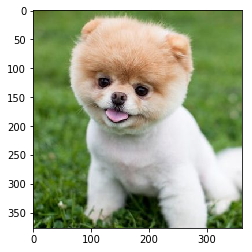

In [32]:
## Executing the algorithm on at least 6 images on computer.

prediction('dogImages/test_images/test1.jpg')

It is not a Dog neither a Human


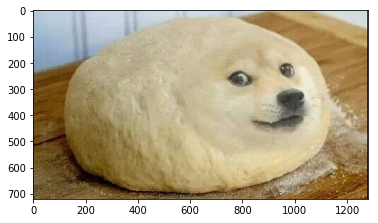

In [33]:
prediction('dogImages/test_images/test2.jpg')

It is not a Dog neither a Human


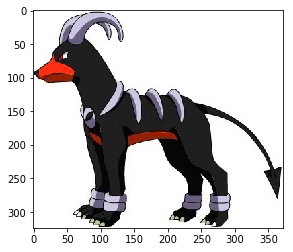

In [34]:
prediction('dogImages/test_images/test3.jpg')

It is not a Dog neither a Human


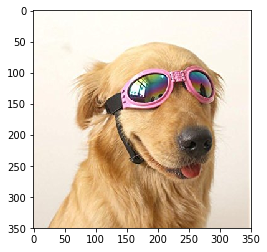

In [35]:
prediction('dogImages/test_images/test4.jpg')

It is not a Dog neither a Human


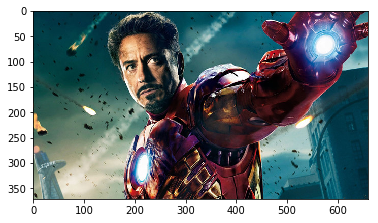

In [36]:
prediction('dogImages/test_images/test5.jpg')

Yeh! It's a Dog.
Breed of this Dog is Afghan_hound


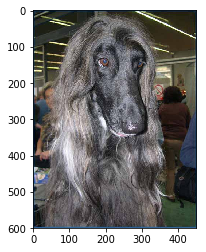

In [37]:
prediction('dogImages/test_images/test6.jpg')